In [223]:
from __future__ import division
import os
import string
import cufflinks as cf
import pandas as pd
import numpy as np
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import seaborn as sns
from scipy import stats, integrate
from scipy.stats import t
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(rc={'figure.figsize':(100,60)},font='sans-serif', font_scale=4,color_codes=True)
np.random.seed(sum(map(ord,"distributions")))

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
cf.set_config_file(offline=True,world_readable=True,theme='ggplot')
df = pd.read_csv('/Users/nickpourazima/GitHub/he-sm/Completed Tests/Combo/Combo_Latest.csv')
users = ['394','412','390','399','486','591','510','729','932','521','514','379']
testList = ['A1a1','A1a2','A1a3','A1a4','A1b1','A1b2','A1b3','A1b4','A2a1','A2a2','A2a3','A2a4','A2b1','A2b2','A2b3','A2b4',
       'A3a1','A3a2','A3a3','A3a4','A3b1','A3b2','A3b3','A3b4','A4a1','A4a2','A4a3','A4a4','A4b1','A4b2','A4b3','A4b4',
       'H1a1','H1a2','H1a3','H1a4','H1b1','H1b2','H1b3','H1b4','H2a1','H2a2','H2a3','H2a4','H2b1','H2b2','H2b3','H2b4']
#            'P1H1a1','P2H1a2','P3H1b1','P4H1b2','P5H1b3','P6A1a2','P7A1b1','P8A2a1']
df = df[df.Test.isin(testList)]
# df.IOI = pd.to_timedelta((df.IOI),unit='ms')/np.timedelta64(1, 'ms')
# df.to_csv("Combo2.csv")

In [249]:
def kde_plot(df, conditions, dv, col_name, save_file=False):
    sns.set_style('white')
    sns.set_style('ticks')
    fig, ax = plt.subplots()
 
    for condition in conditions:
        condition_data = df[(df[col_name] == condition)][dv]
        sns.kdeplot(condition_data, shade=True, label=condition)
        
    sns.despine()
    
    if save_file:
        plt.savefig("kernel_density_estimate_seaborn_python_response"
                     "-time.png")
    plt.show()
    
def cdf(df, conditions=['A1a1', 'H1a1']):
 
    data = {i: df[(df.Test == conditions[i])] for i in range(len(
        conditions))}
    plot_data = []
 
    for i, condition in enumerate(conditions):
 
        rt = data[i]["Sanitized Asynchrony"].sort_values()
        yvals = np.arange(len(rt)) / float(len(rt))
 
        # Append it to the data
        cond = [condition]*len(yvals)
 
        df = pd.DataFrame(dict(dens=yvals, dv=rt, condition=cond))
        plot_data.append(df)
 
    plot_data = pd.concat(plot_data, axis=0)
 
    return plot_data

def cdf_plot(cdf_data, save_file=False, legend=True):
    sns.set_style('white')
    sns.set_style('ticks')
    sns.set(rc={'figure.figsize':(100,60)},font='sans-serif', font_scale=1,color_codes=True)
    g = sns.FacetGrid(cdf_data, size=10, hue="condition")
    g.map(plt.plot, "dv", "dens", alpha=.7, linewidth=1)
    if legend:
        g.add_legend(title="Congruency")
    g.set_axis_labels("Response Time (ms.)", "Probability")
    g.fig.suptitle('Cumulative Distribution Function')
 
    if save_file:
        g.savefig("cumulative_distribution_function_seaborn_python_response"
                  "-time.png")
 
    plt.show()
    
def calc_delta_data(df, subid, dv, condition, conditions=['A1a1',
                                                   'H1a1']):
  
    subjects = pd.Series(df[subid].values.ravel()).unique().tolist()
    subjects.sort()
 
    deciles = np.arange(0.1, 1., 0.1)
 
    cond_one = conditions[0]
    cond_two = conditions[1]
 
    # Frame to store the data (per subject)
    arrays = [np.array([cond_one, cond_two]).repeat(len(deciles)),
              np.array(deciles).tolist() * 2]
    data_delta = pd.DataFrame(columns=subjects, index=arrays)
 
    for subject in subjects:
 
        sub_data_inc = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_one)]
        sub_data_con = df.loc[(df[subid] == subject) & (df[condition] ==
                                                        cond_two)]
 
        inc_q = sub_data_inc[dv].quantile(q=deciles).values
        con_q = sub_data_con[dv].quantile(q=deciles).values
        for i, dec in enumerate(deciles):
            data_delta.loc[(cond_one, dec)][subject] = inc_q[i]
            data_delta.loc[(cond_two, dec)][subject] = con_q[i]
 
 
    # Aggregate deciles
    data_delta = data_delta.mean(axis=1).unstack(level=0)
    # Calculate difference
    data_delta['Diff'] = data_delta[cond_one] - data_delta[cond_two]
    # Calculate average
    data_delta['Average'] = (data_delta[cond_one] + data_delta[cond_two]) / 2
 
    return data_delta

def delta_plot(delta_data, save_file=False):
 
    ymax = delta_data['Diff'].max() + 10
    ymin = -10
    xmin = delta_data['Average'].min() - 20
    xmax = delta_data['Average'].max() + 20
 
    sns.set_style('white')
    g = sns.FacetGrid(delta_data, ylim=(ymin, ymax), xlim=(xmin, xmax), size=8)
    g.map(plt.scatter, "Average", "Diff", s=50, alpha=.7, linewidth=1,
          edgecolor="white")
    g.map(plt.plot, "Average", "Diff", alpha=.7, linewidth=1)
    g.set_axis_labels("Avarage RTs (ms.)", "Effect (ms.)")
    g.fig.suptitle('Delta Plot')
    if save_file:
        g.savefig("delta_plot_seaborn_python_response-time.png")
 
    plt.show()

In [20]:
i=0;
j=0;
for item in pd.loc[pd['User ID']]:
    if(item == users[i]):
        for test in pd['Test']:
            if(test == testList[j]):
                pd['Corrected Mean'] = pd['Sanitized Asynchrony'].mean(skipna=False)
            else:
                j=j+1
    else:
        i=i+1

IndexError: list index out of range

In [18]:
filter1DF = pd.loc[(pd['User ID']==591)]
i=0;
j=0;
for x in filter1DF['Test']:
    if (x == testList[i]):
        filter1DF['Phase Correction Response'] = filter1DF['Sanitized Asynchrony'].shift(-1)-filter1DF['Sanitized Asynchrony']
    else:
        i=i+1
# print(filter1DF['Phase Correction Response'])
# filter1DF['Phase Correction Response'] = filter1DF['Test'].apply(lambda x: filter1DF['Sanitized Asynchrony'].shift(-1)-filter1DF['Sanitized Asynchrony'] if x == 'A1a1' else np.NaN)
filter1DF.to_csv("591 Mod.csv")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice fro

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

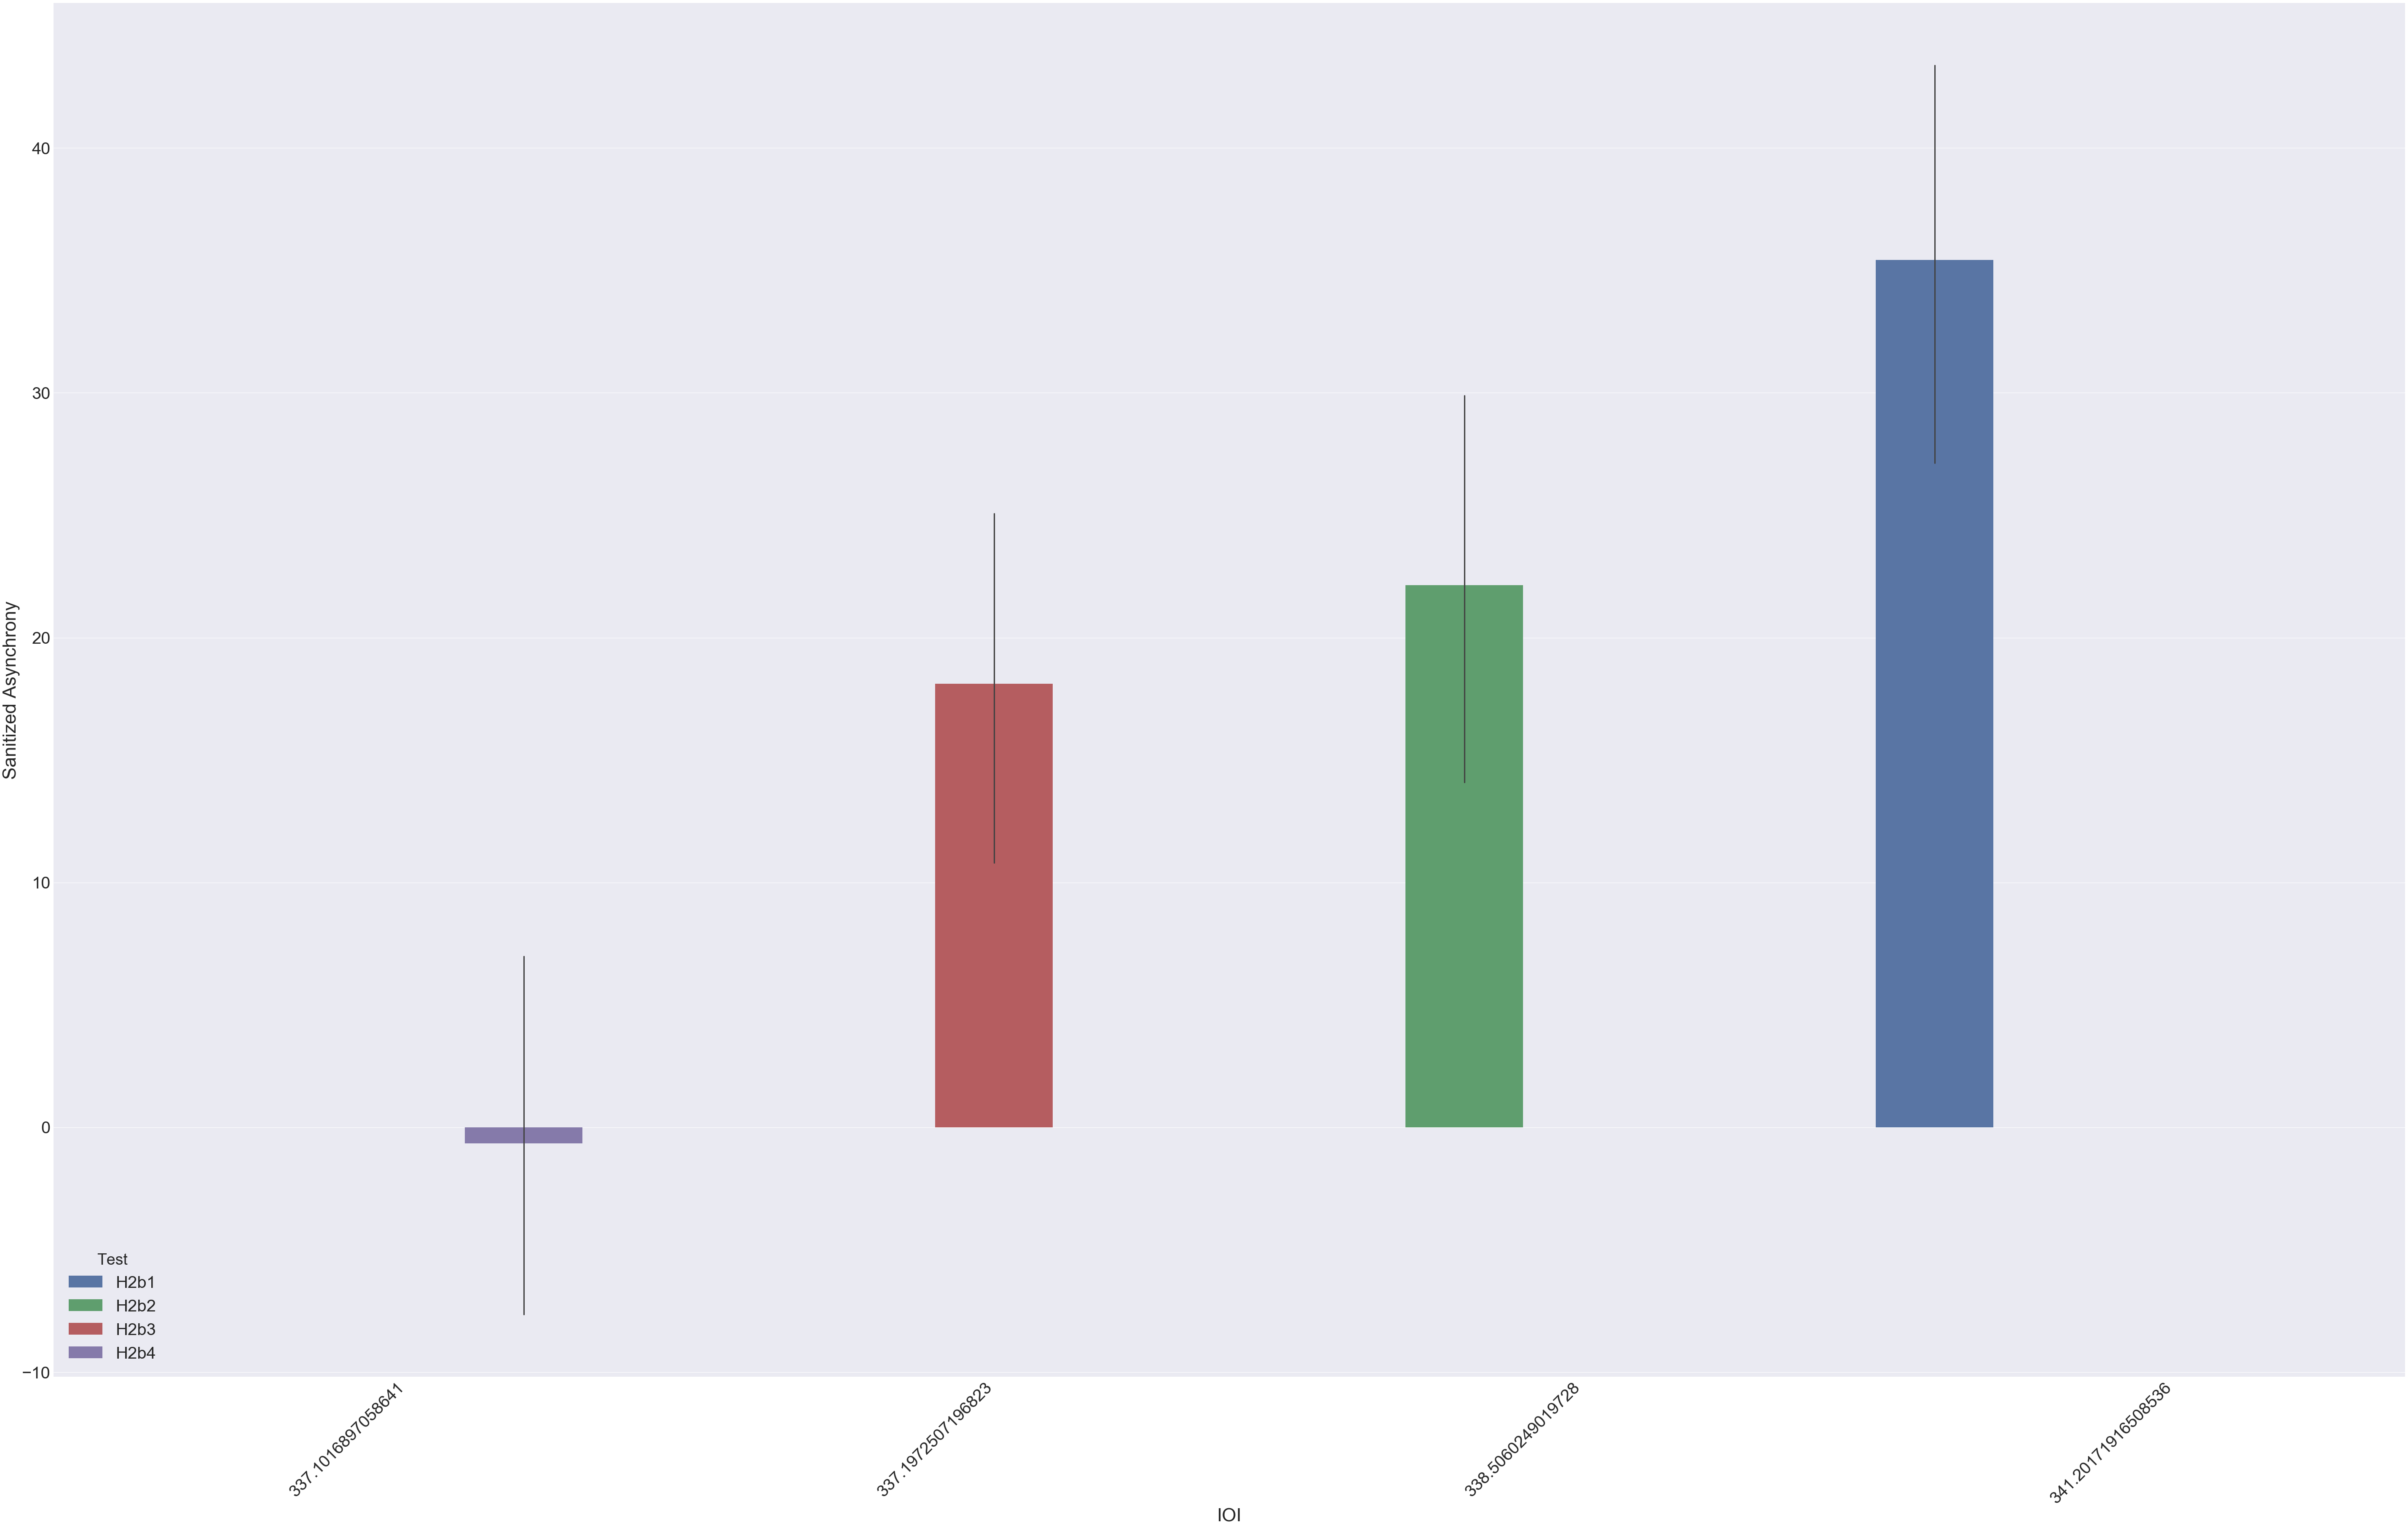

In [196]:
newList = ['H2b1','H2b2','H2b3','H2b4']
# df.IOI.describe()
newdf = df[df.Test.isin(newList)]
newdf.IOI[newdf.Test==newList[0]] = newdf.IOI.mean()
newdf.IOI[newdf.Test==newList[1]] = newdf.IOI.mean()
newdf.IOI[newdf.Test==newList[2]] = newdf.IOI.mean()
newdf.IOI[newdf.Test==newList[3]] = newdf.IOI.mean()
sns.barplot(y="Sanitized Asynchrony",x="IOI",data=newdf,hue="Test")
plt.xticks(rotation=45)

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning:

invalid value encountered in less



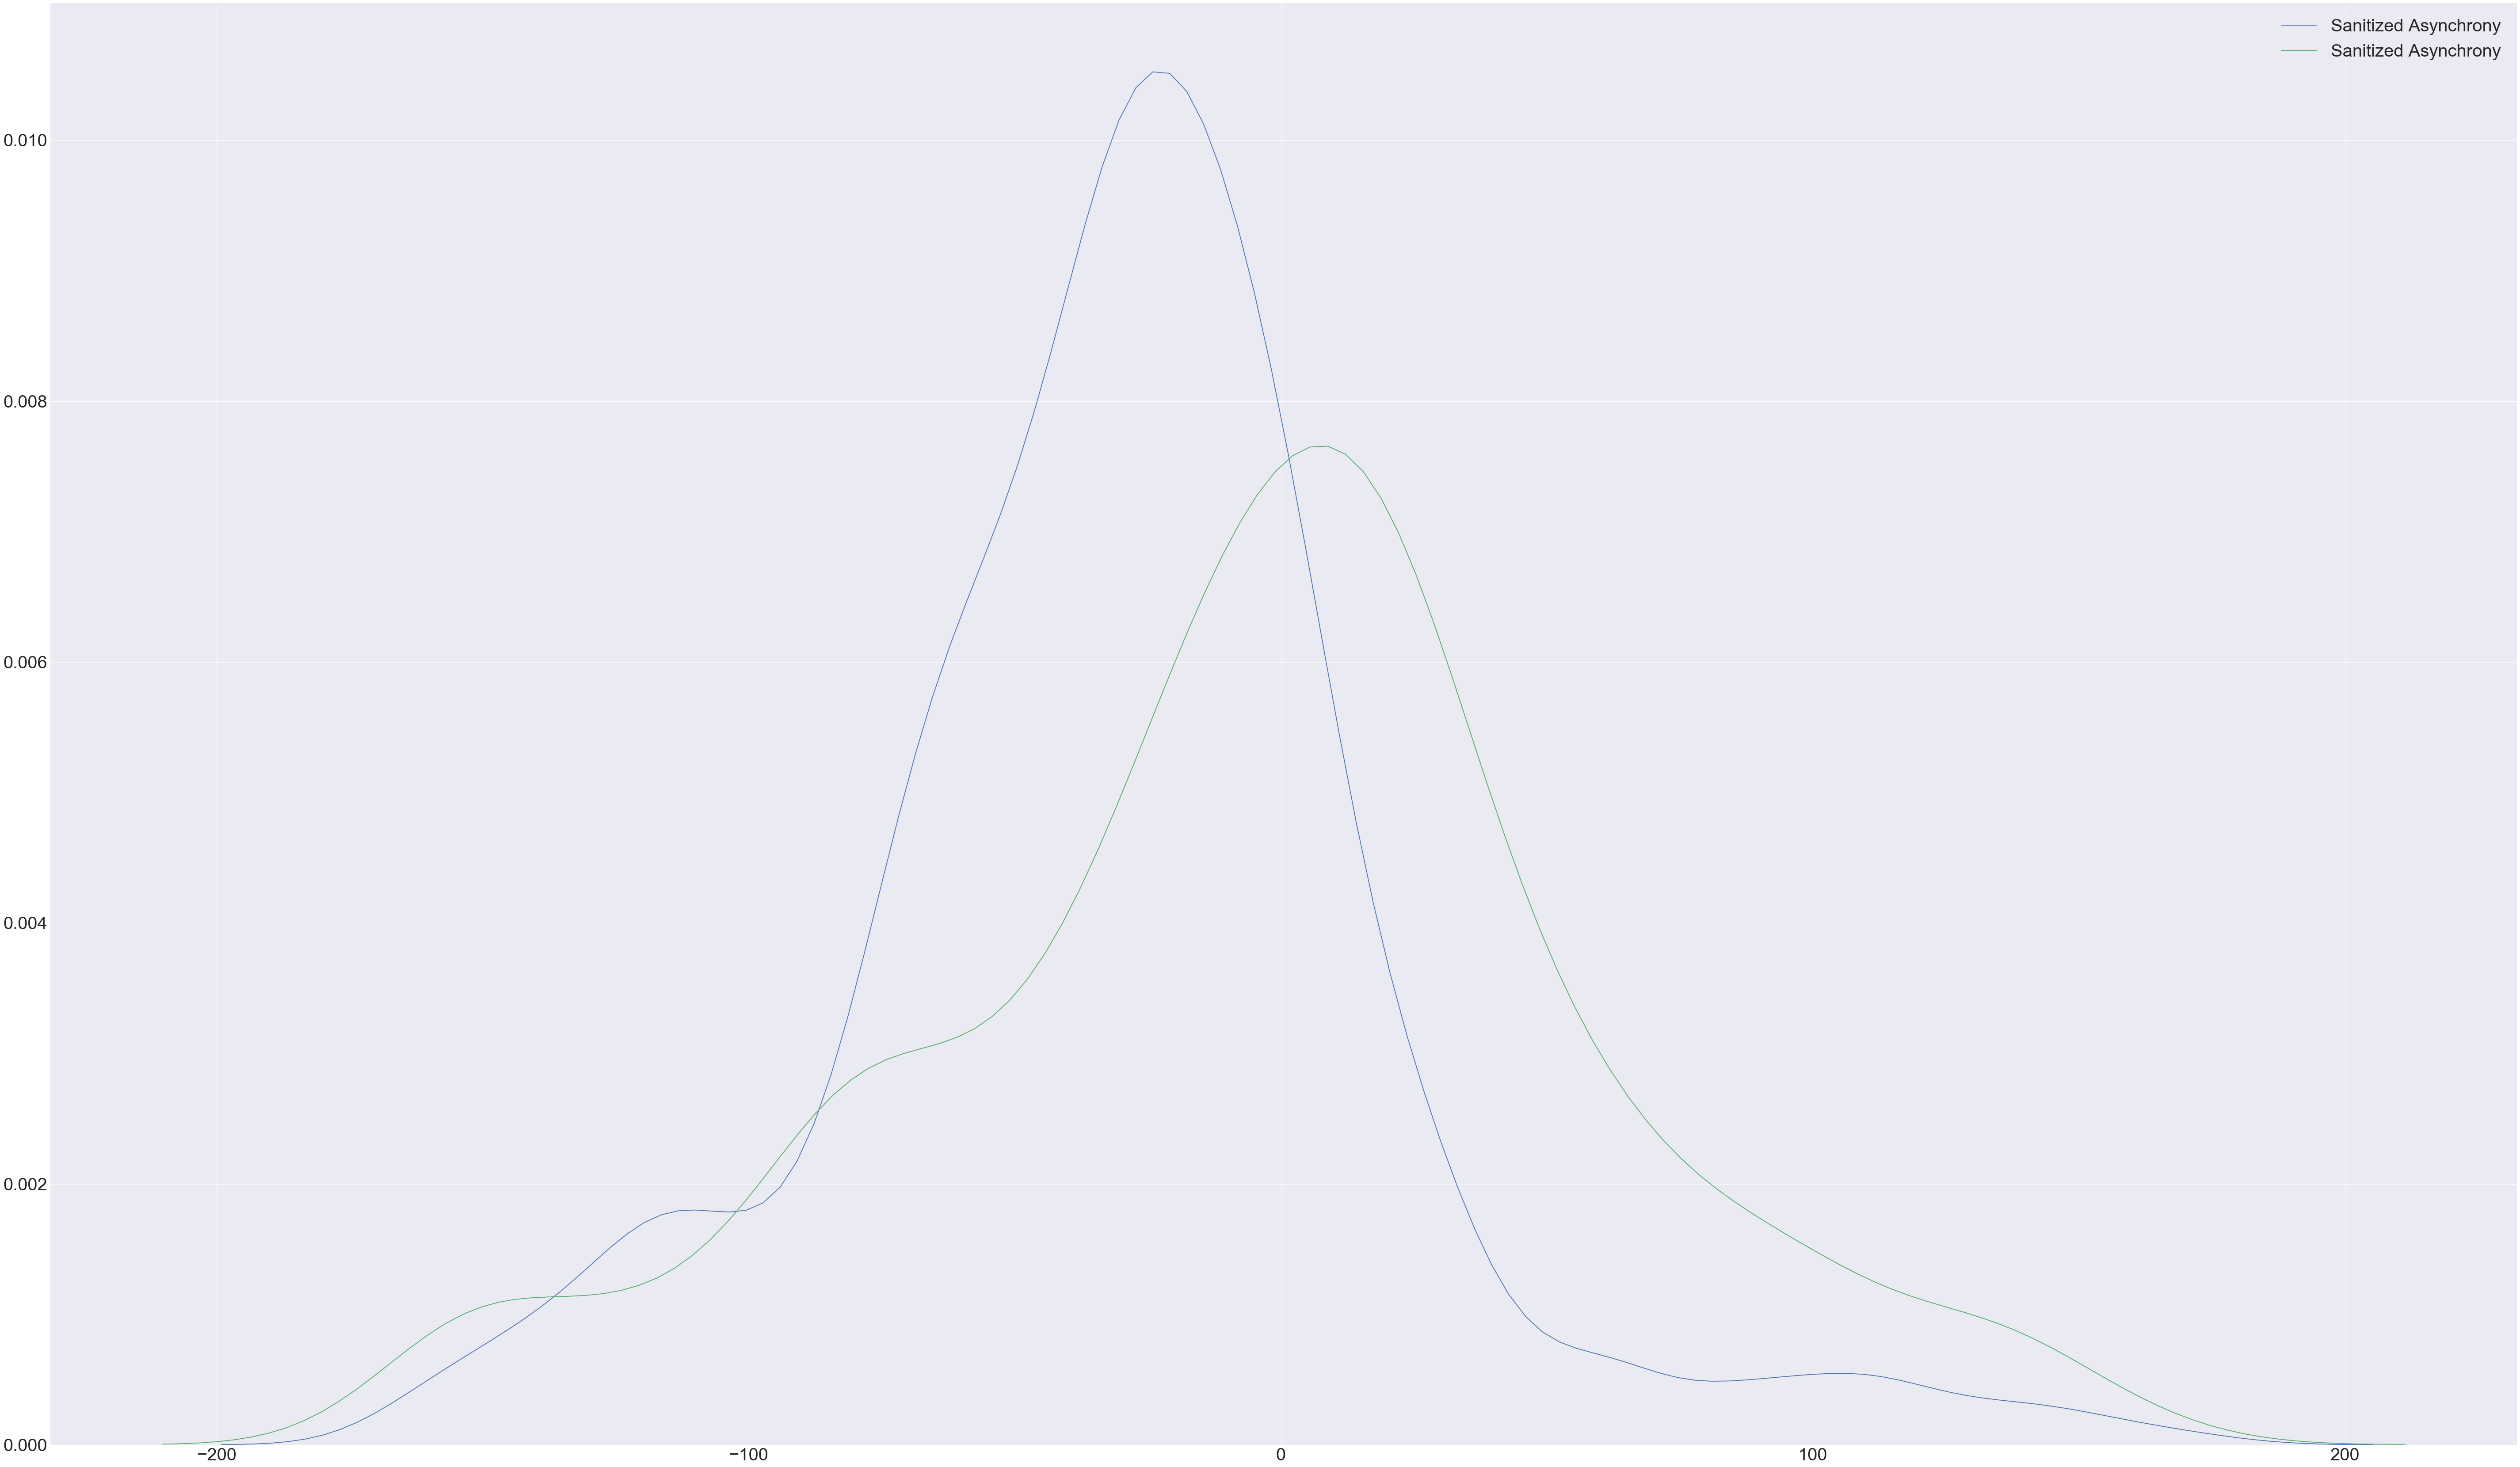

In [220]:
sns.kdeplot(df["Sanitized Asynchrony"][df.Test == testList[3]])
sns.kdeplot(df["Sanitized Asynchrony"][df.Test == testList[35]])

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning:

invalid value encountered in less



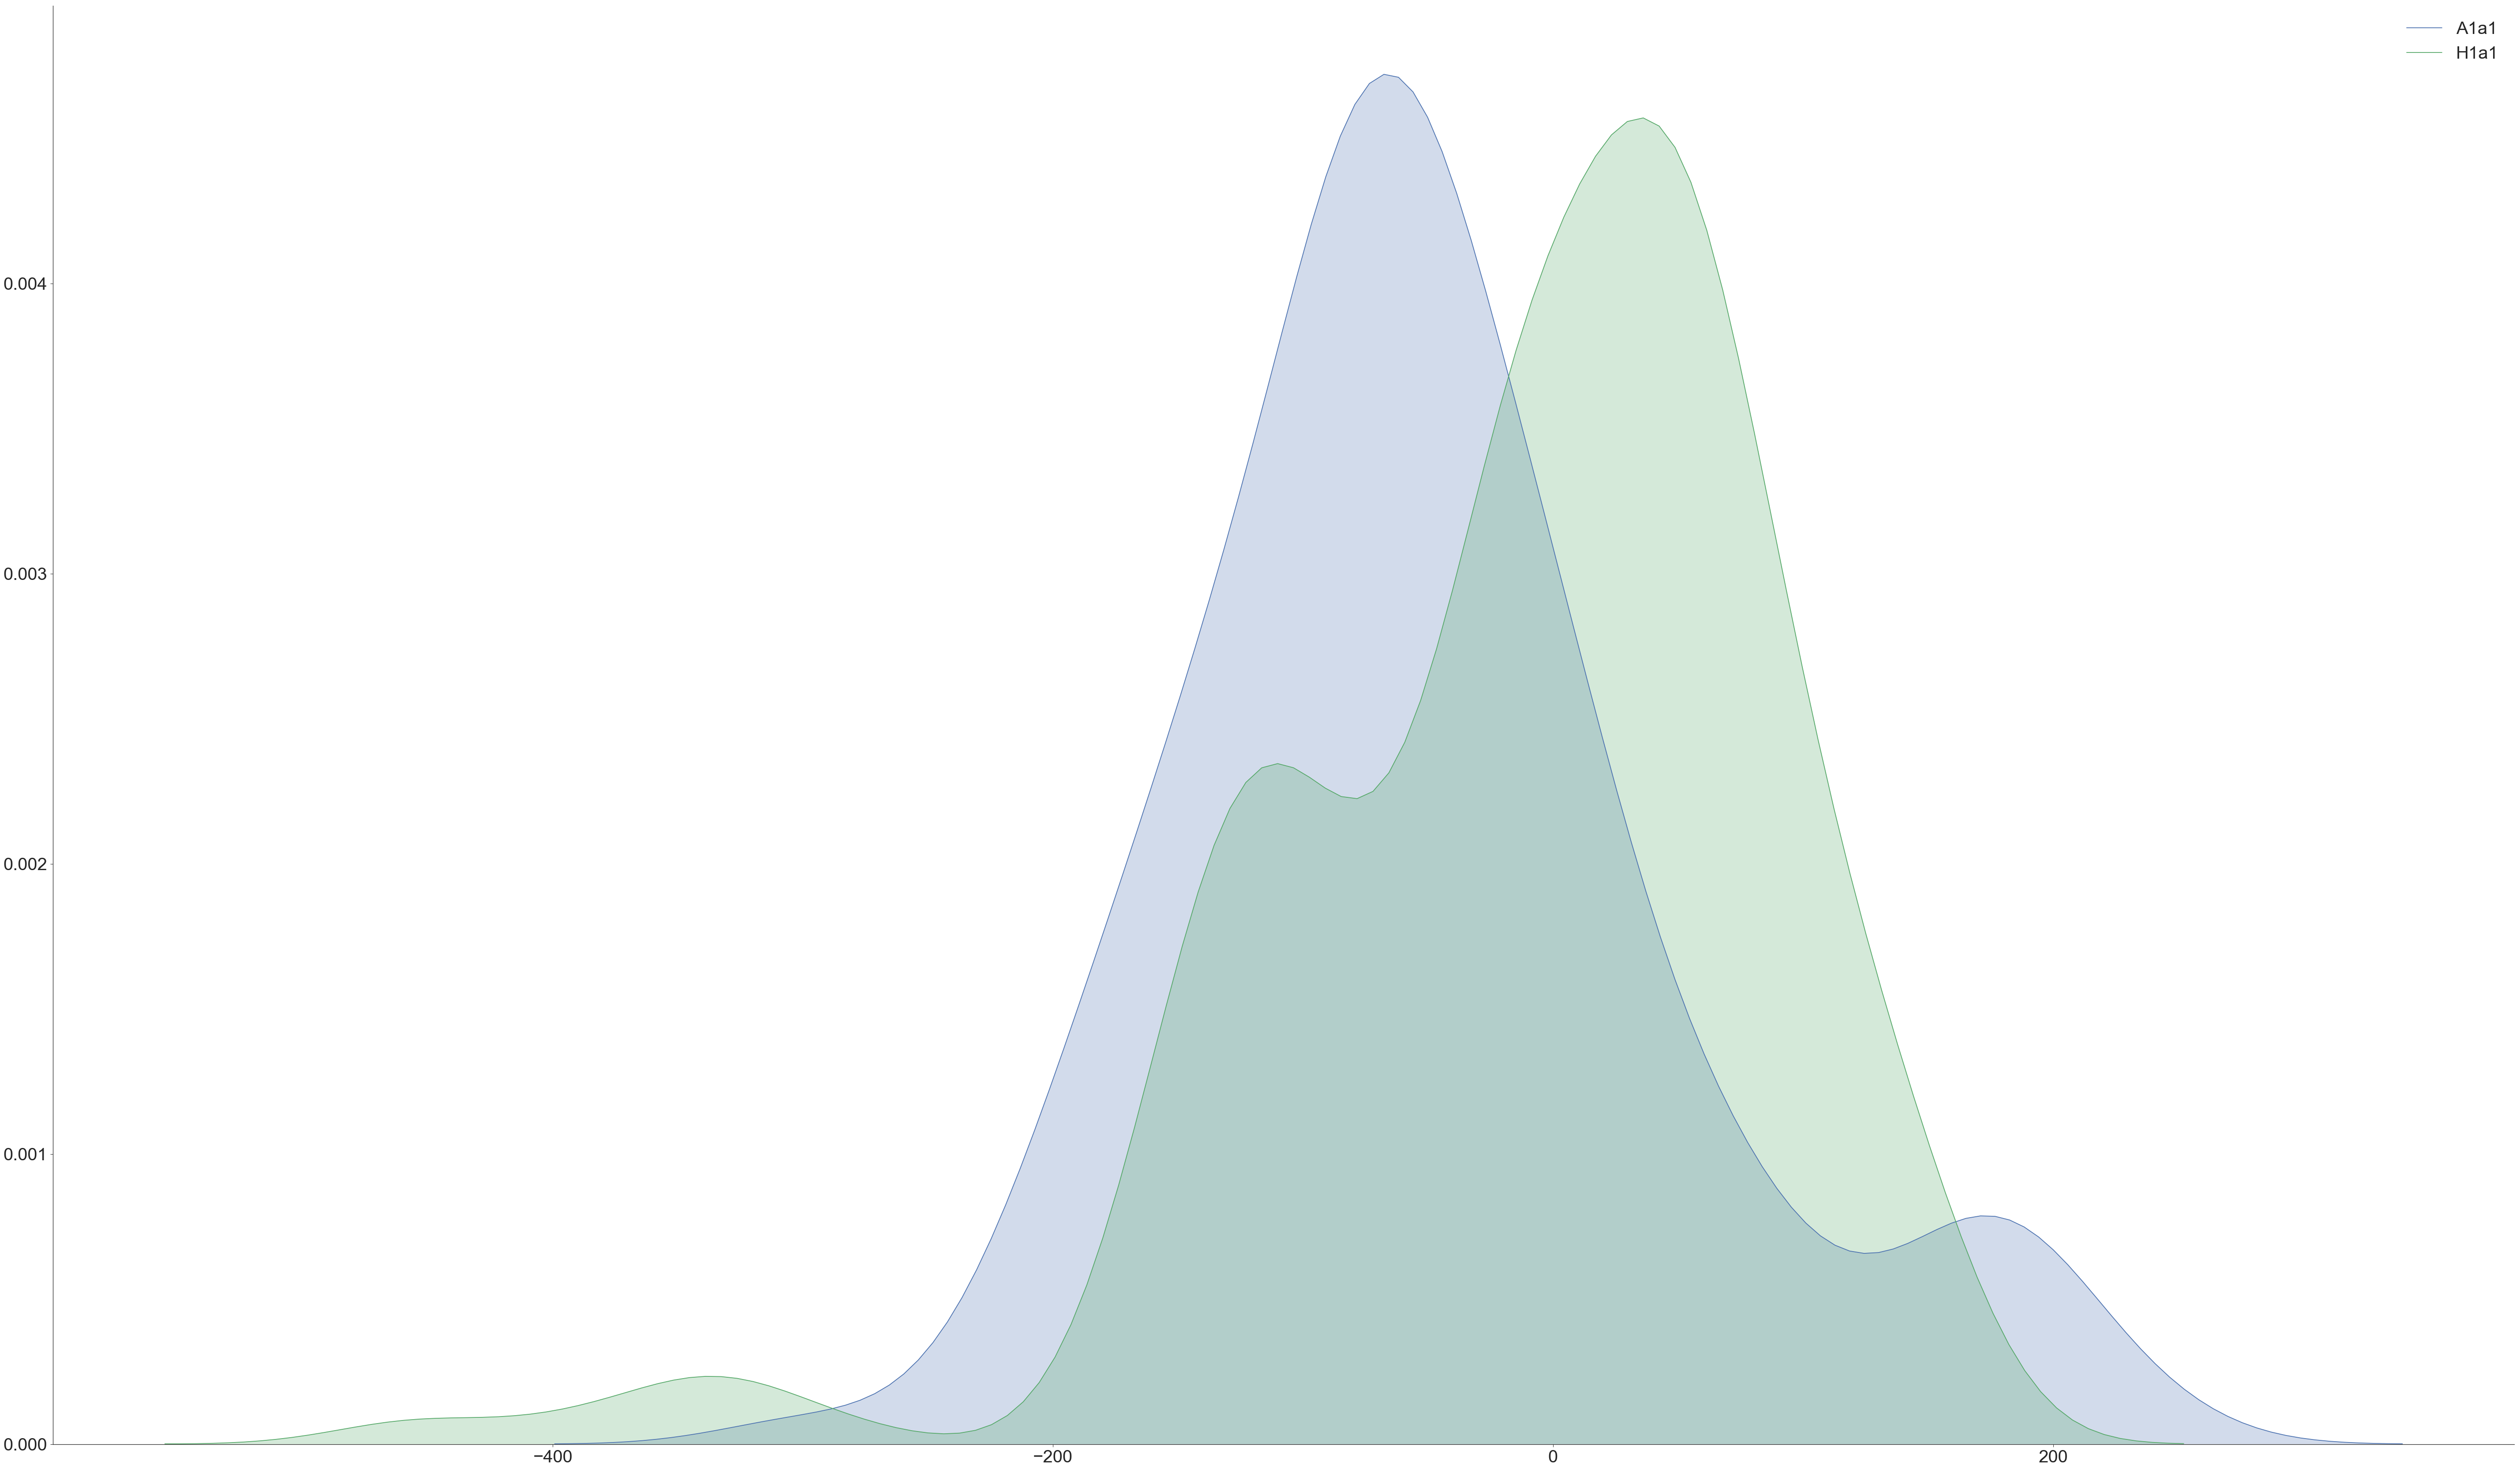

In [222]:
kde_plot(df, ['A1a1', 'H1a1'], 'Sanitized Asynchrony', 'Test', save_file=False);

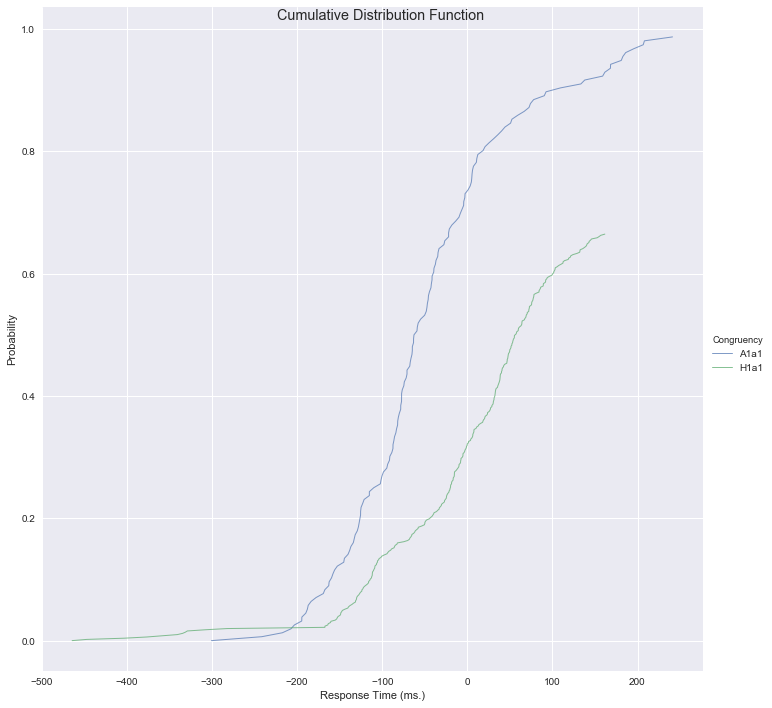

In [274]:
cdf_dat = cdf(df, conditions=['A1a1', 'H1a1'])
cdf_plot(cdf_dat, legend=True, save_file=False)

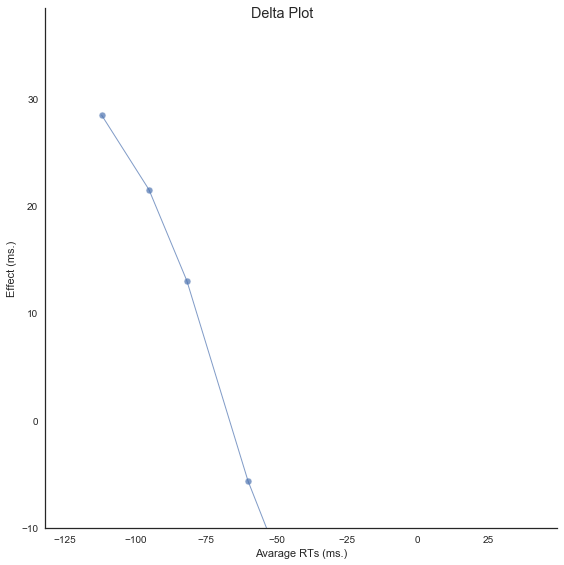

In [272]:
d_data = calc_delta_data(df, "User ID", "Sanitized Asynchrony", "Test", ['A1a1','H1a1'])
delta_plot(d_data)

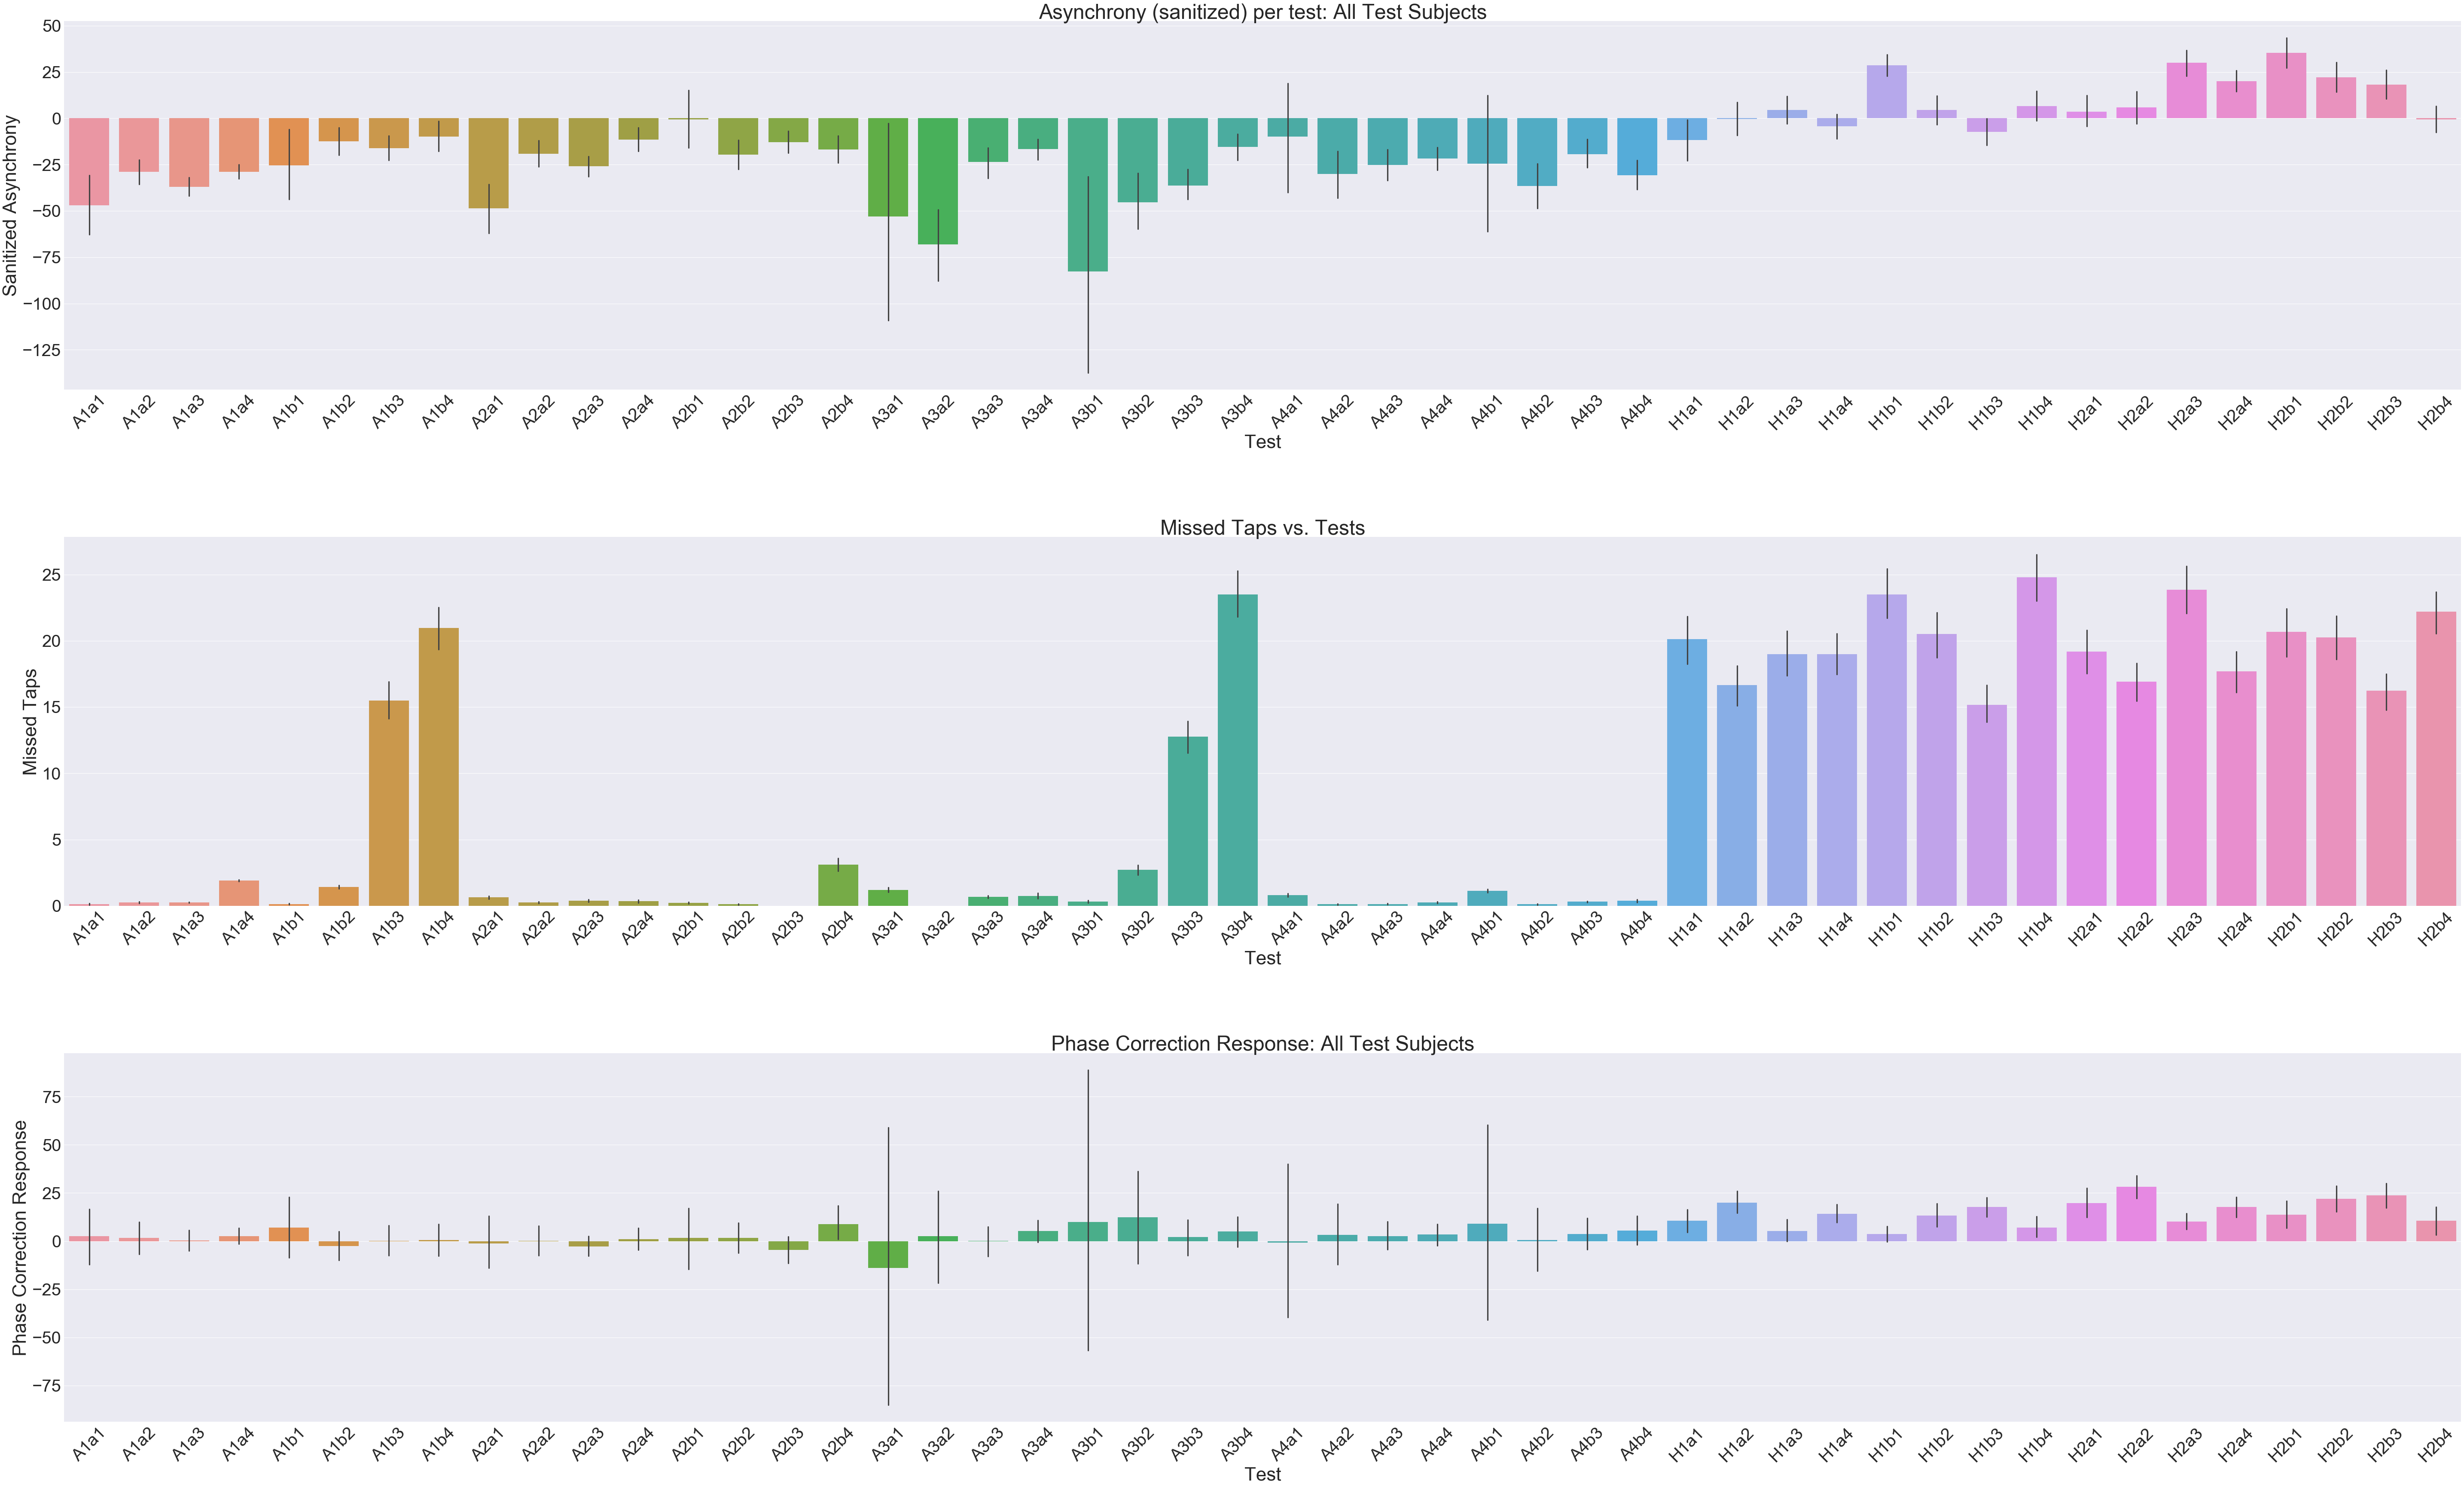

In [169]:
fig, axs = plt.subplots(nrows=3);
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=45)
sns.barplot(x="Test",y="Sanitized Asynchrony",data=df,dodge=True,ax=axs[0],order=testList).set_title("Asynchrony (sanitized) per test: All Test Subjects");
sns.barplot(x="Test",y="Missed Taps",data=df,dodge=True,ax=axs[1],order=testList).set_title("Missed Taps vs. Tests");
sns.barplot(x="Test",y="Phase Correction Response",data=df,dodge=True,ax=axs[2],order=testList).set_title("Phase Correction Response: All Test Subjects");
plt.savefig('AllSummary.png');

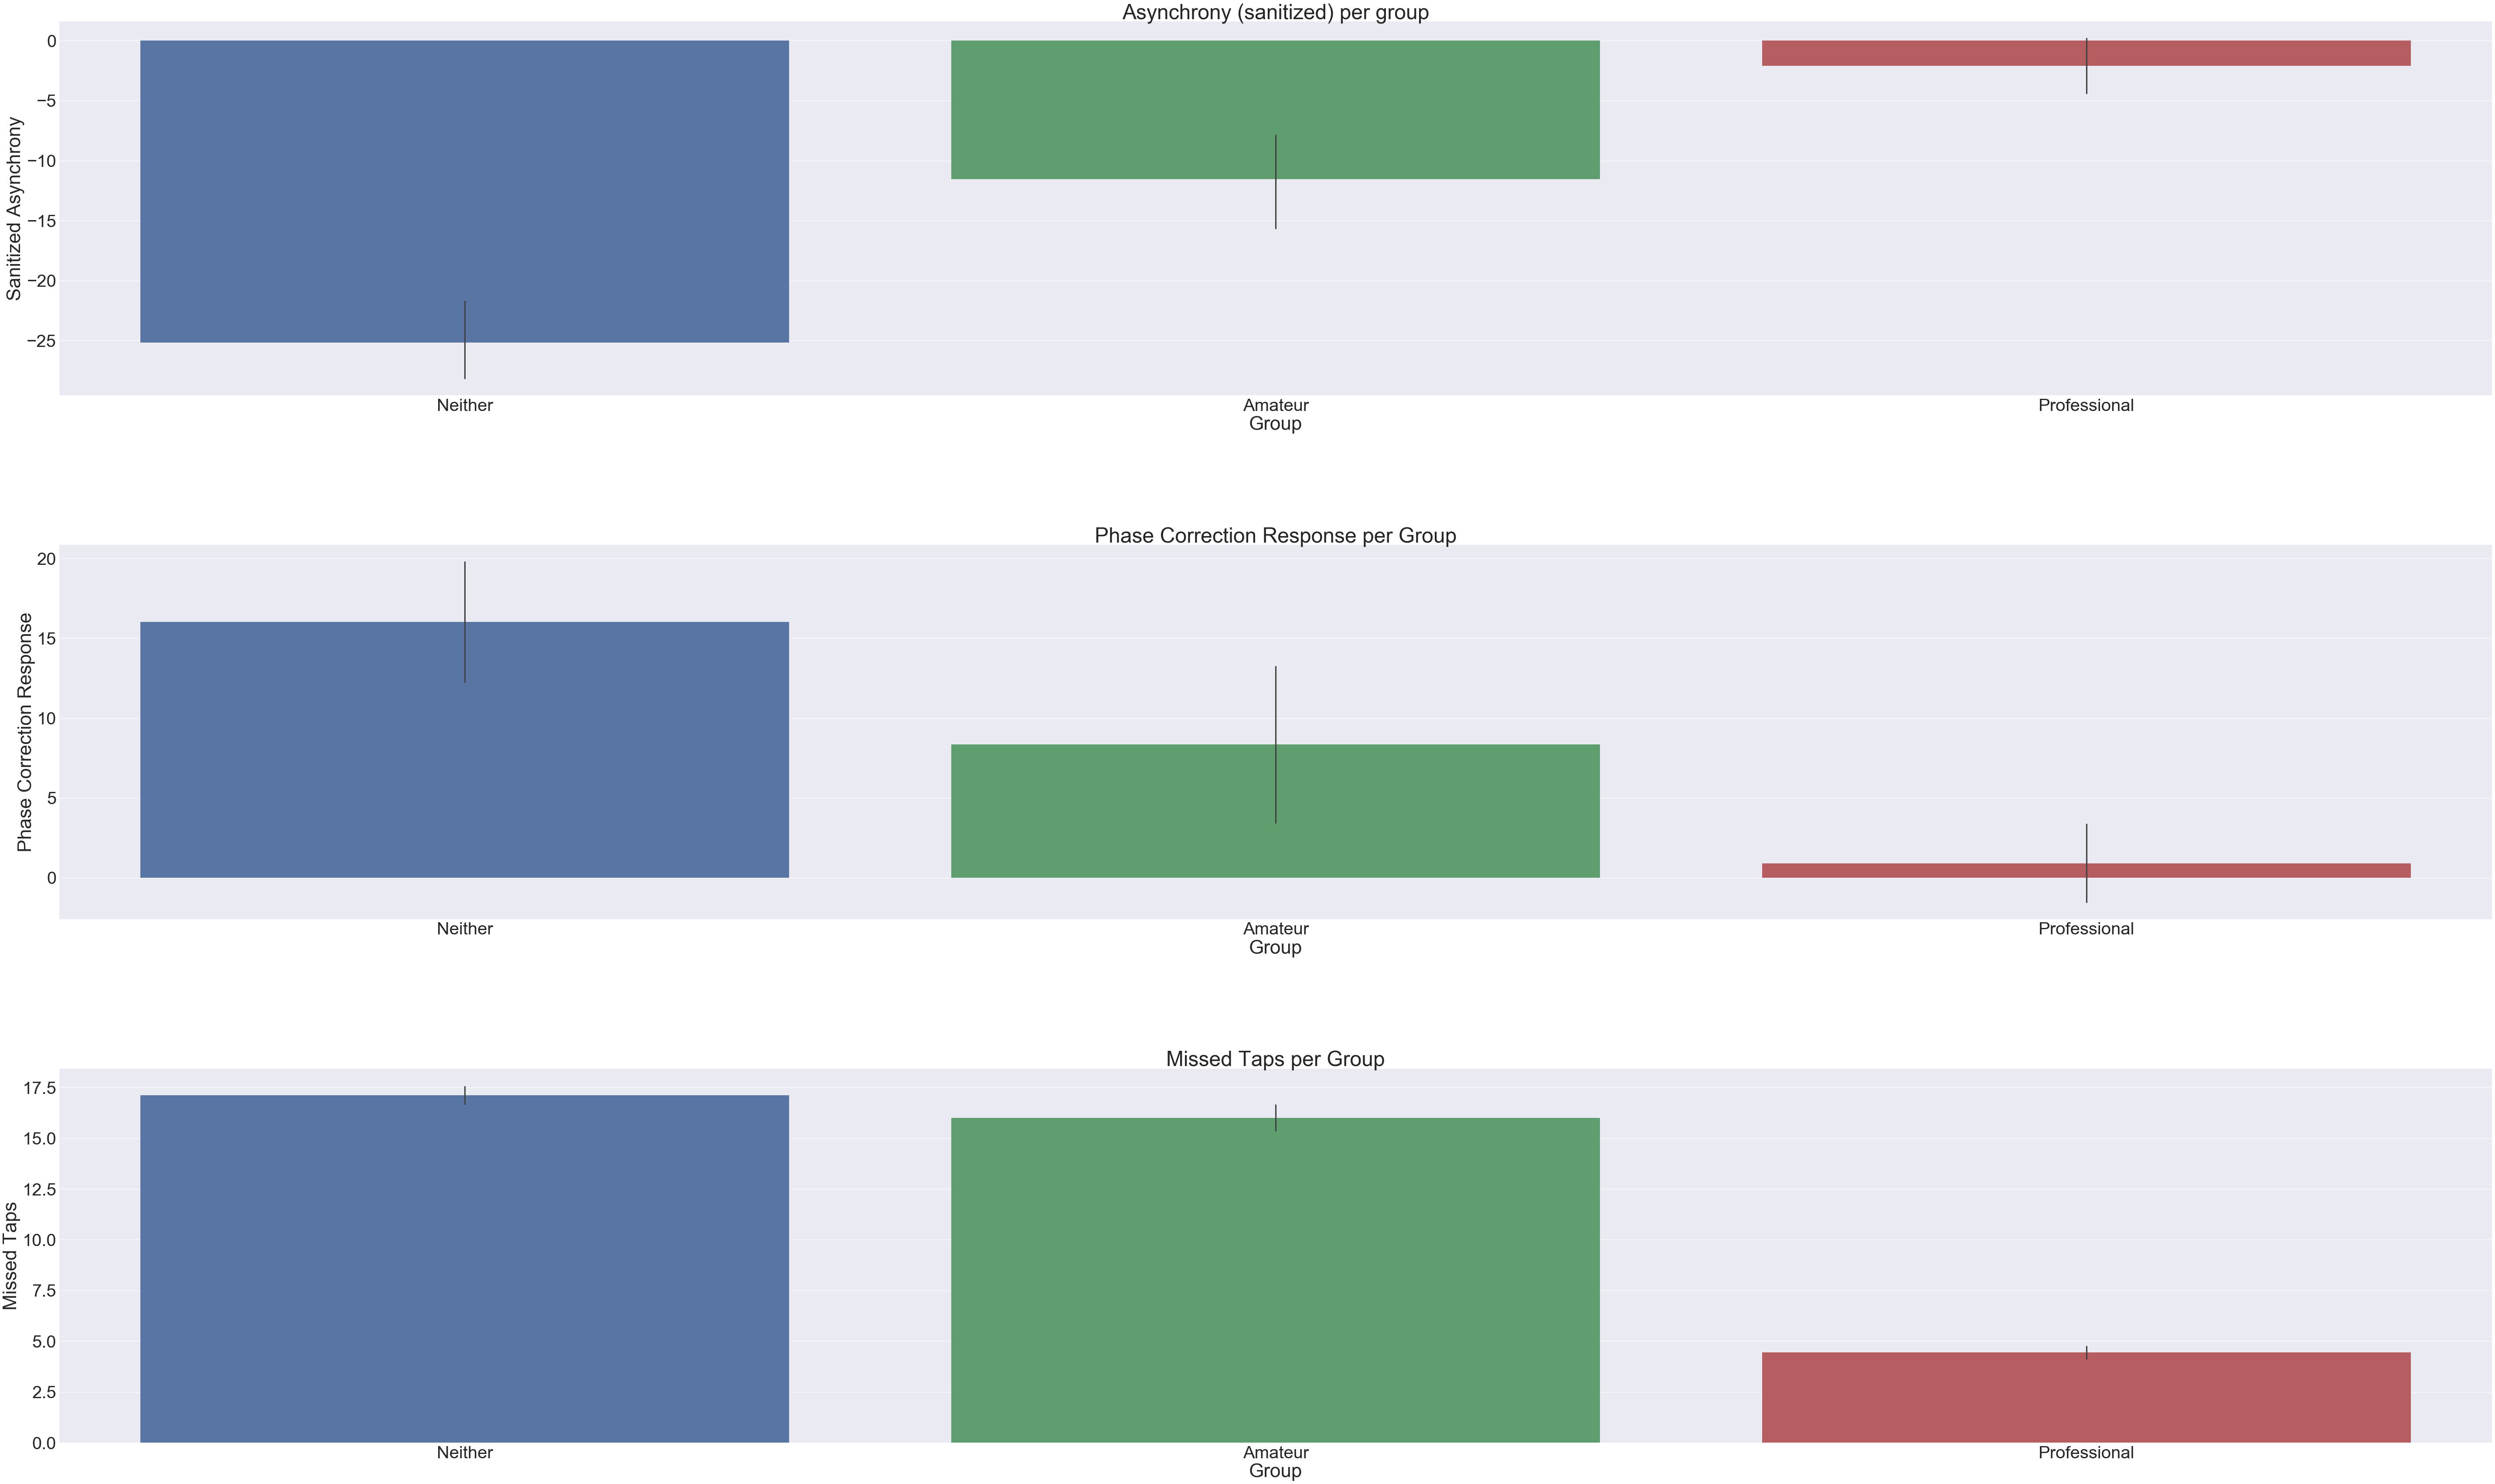

In [170]:
fig, axs = plt.subplots(nrows=3); 
plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.barplot(x="Group",y="Sanitized Asynchrony",data=df,dodge=True,ax=axs[0]).set_title("Asynchrony (sanitized) per group"); 
sns.barplot(x="Group",y="Phase Correction Response",data=df,dodge=True,ax=axs[1]).set_title("Phase Correction Response per Group"); 
sns.barplot(x="Group",y="Missed Taps",data=df,dodge=True,ax=axs[2]).set_title("Missed Taps per Group"); 
plt.savefig('GroupSummaries.png');

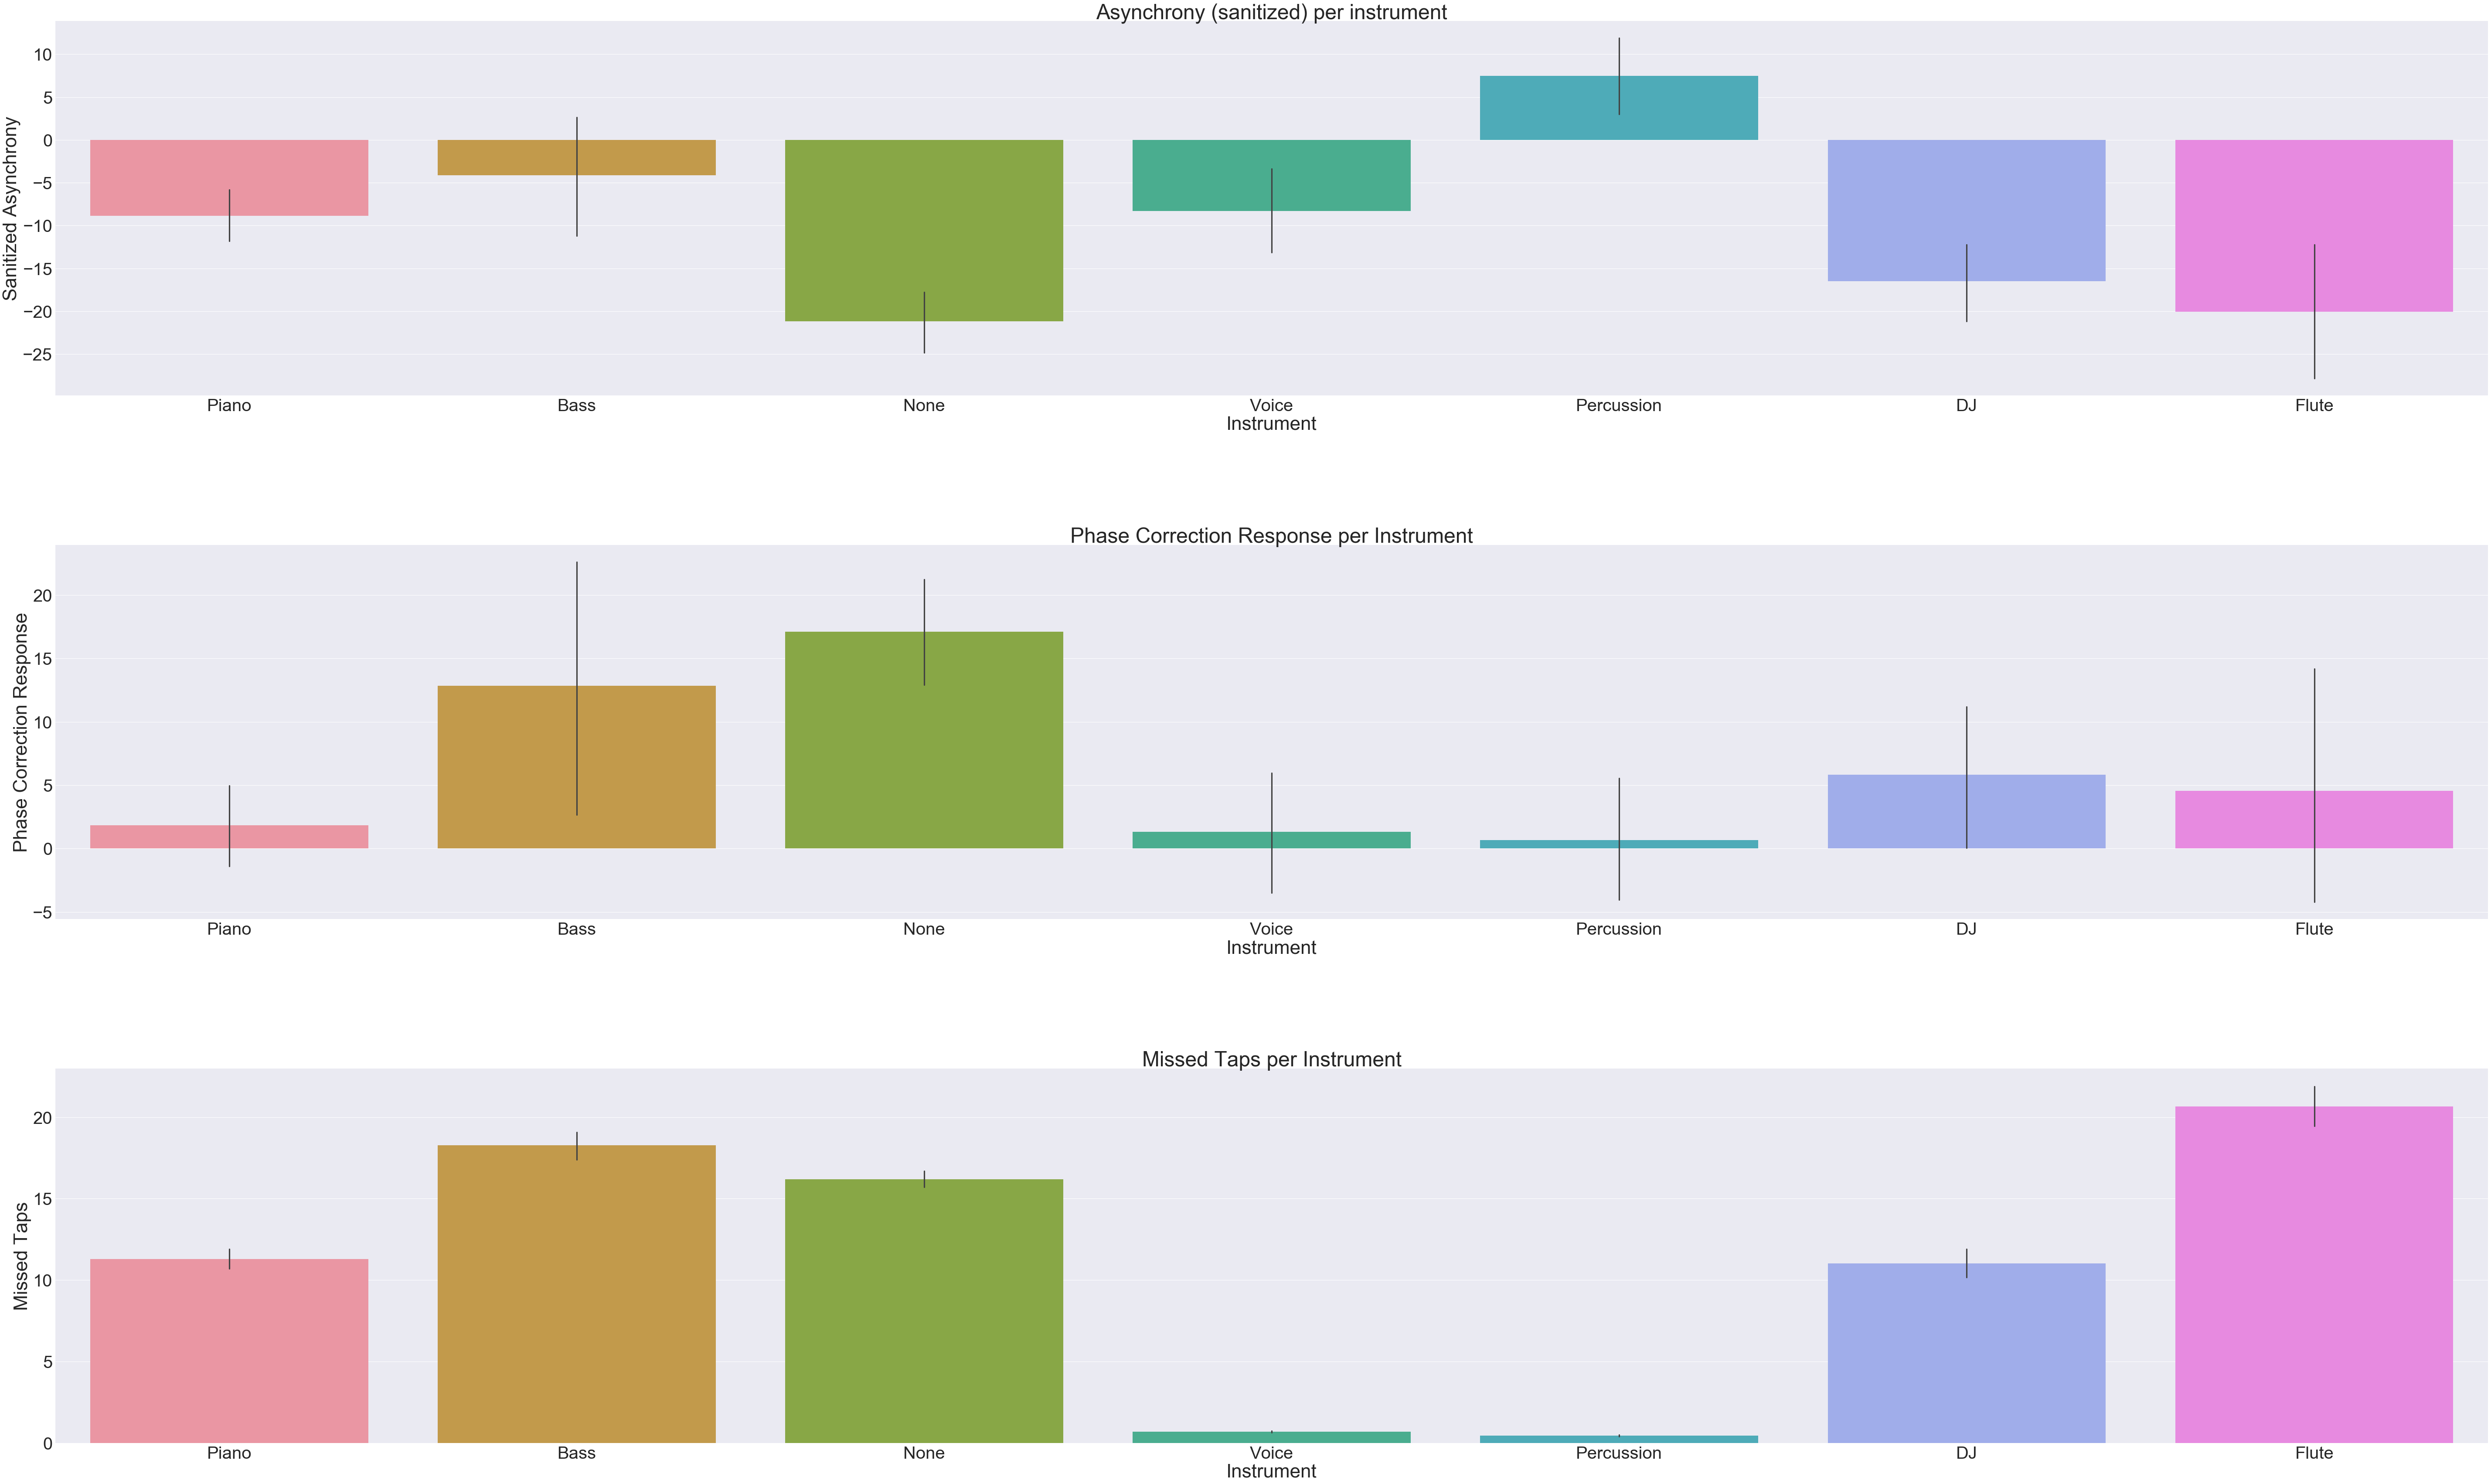

In [171]:
fig, axs = plt.subplots(nrows=3); 
# plt.subplots_adjust(top=.9);
# fig.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
sns.barplot(x="Instrument",y="Sanitized Asynchrony",data=df,dodge=True,ax=axs[0]).set_title("Asynchrony (sanitized) per instrument"); 
sns.barplot(x="Instrument",y="Phase Correction Response",data=df,dodge=True,ax=axs[1]).set_title("Phase Correction Response per Instrument");
sns.barplot(x="Instrument",y="Missed Taps",data=df,dodge=True,ax=axs[2]).set_title("Missed Taps per Instrument");
plt.savefig('InstrumentSummaries.png');

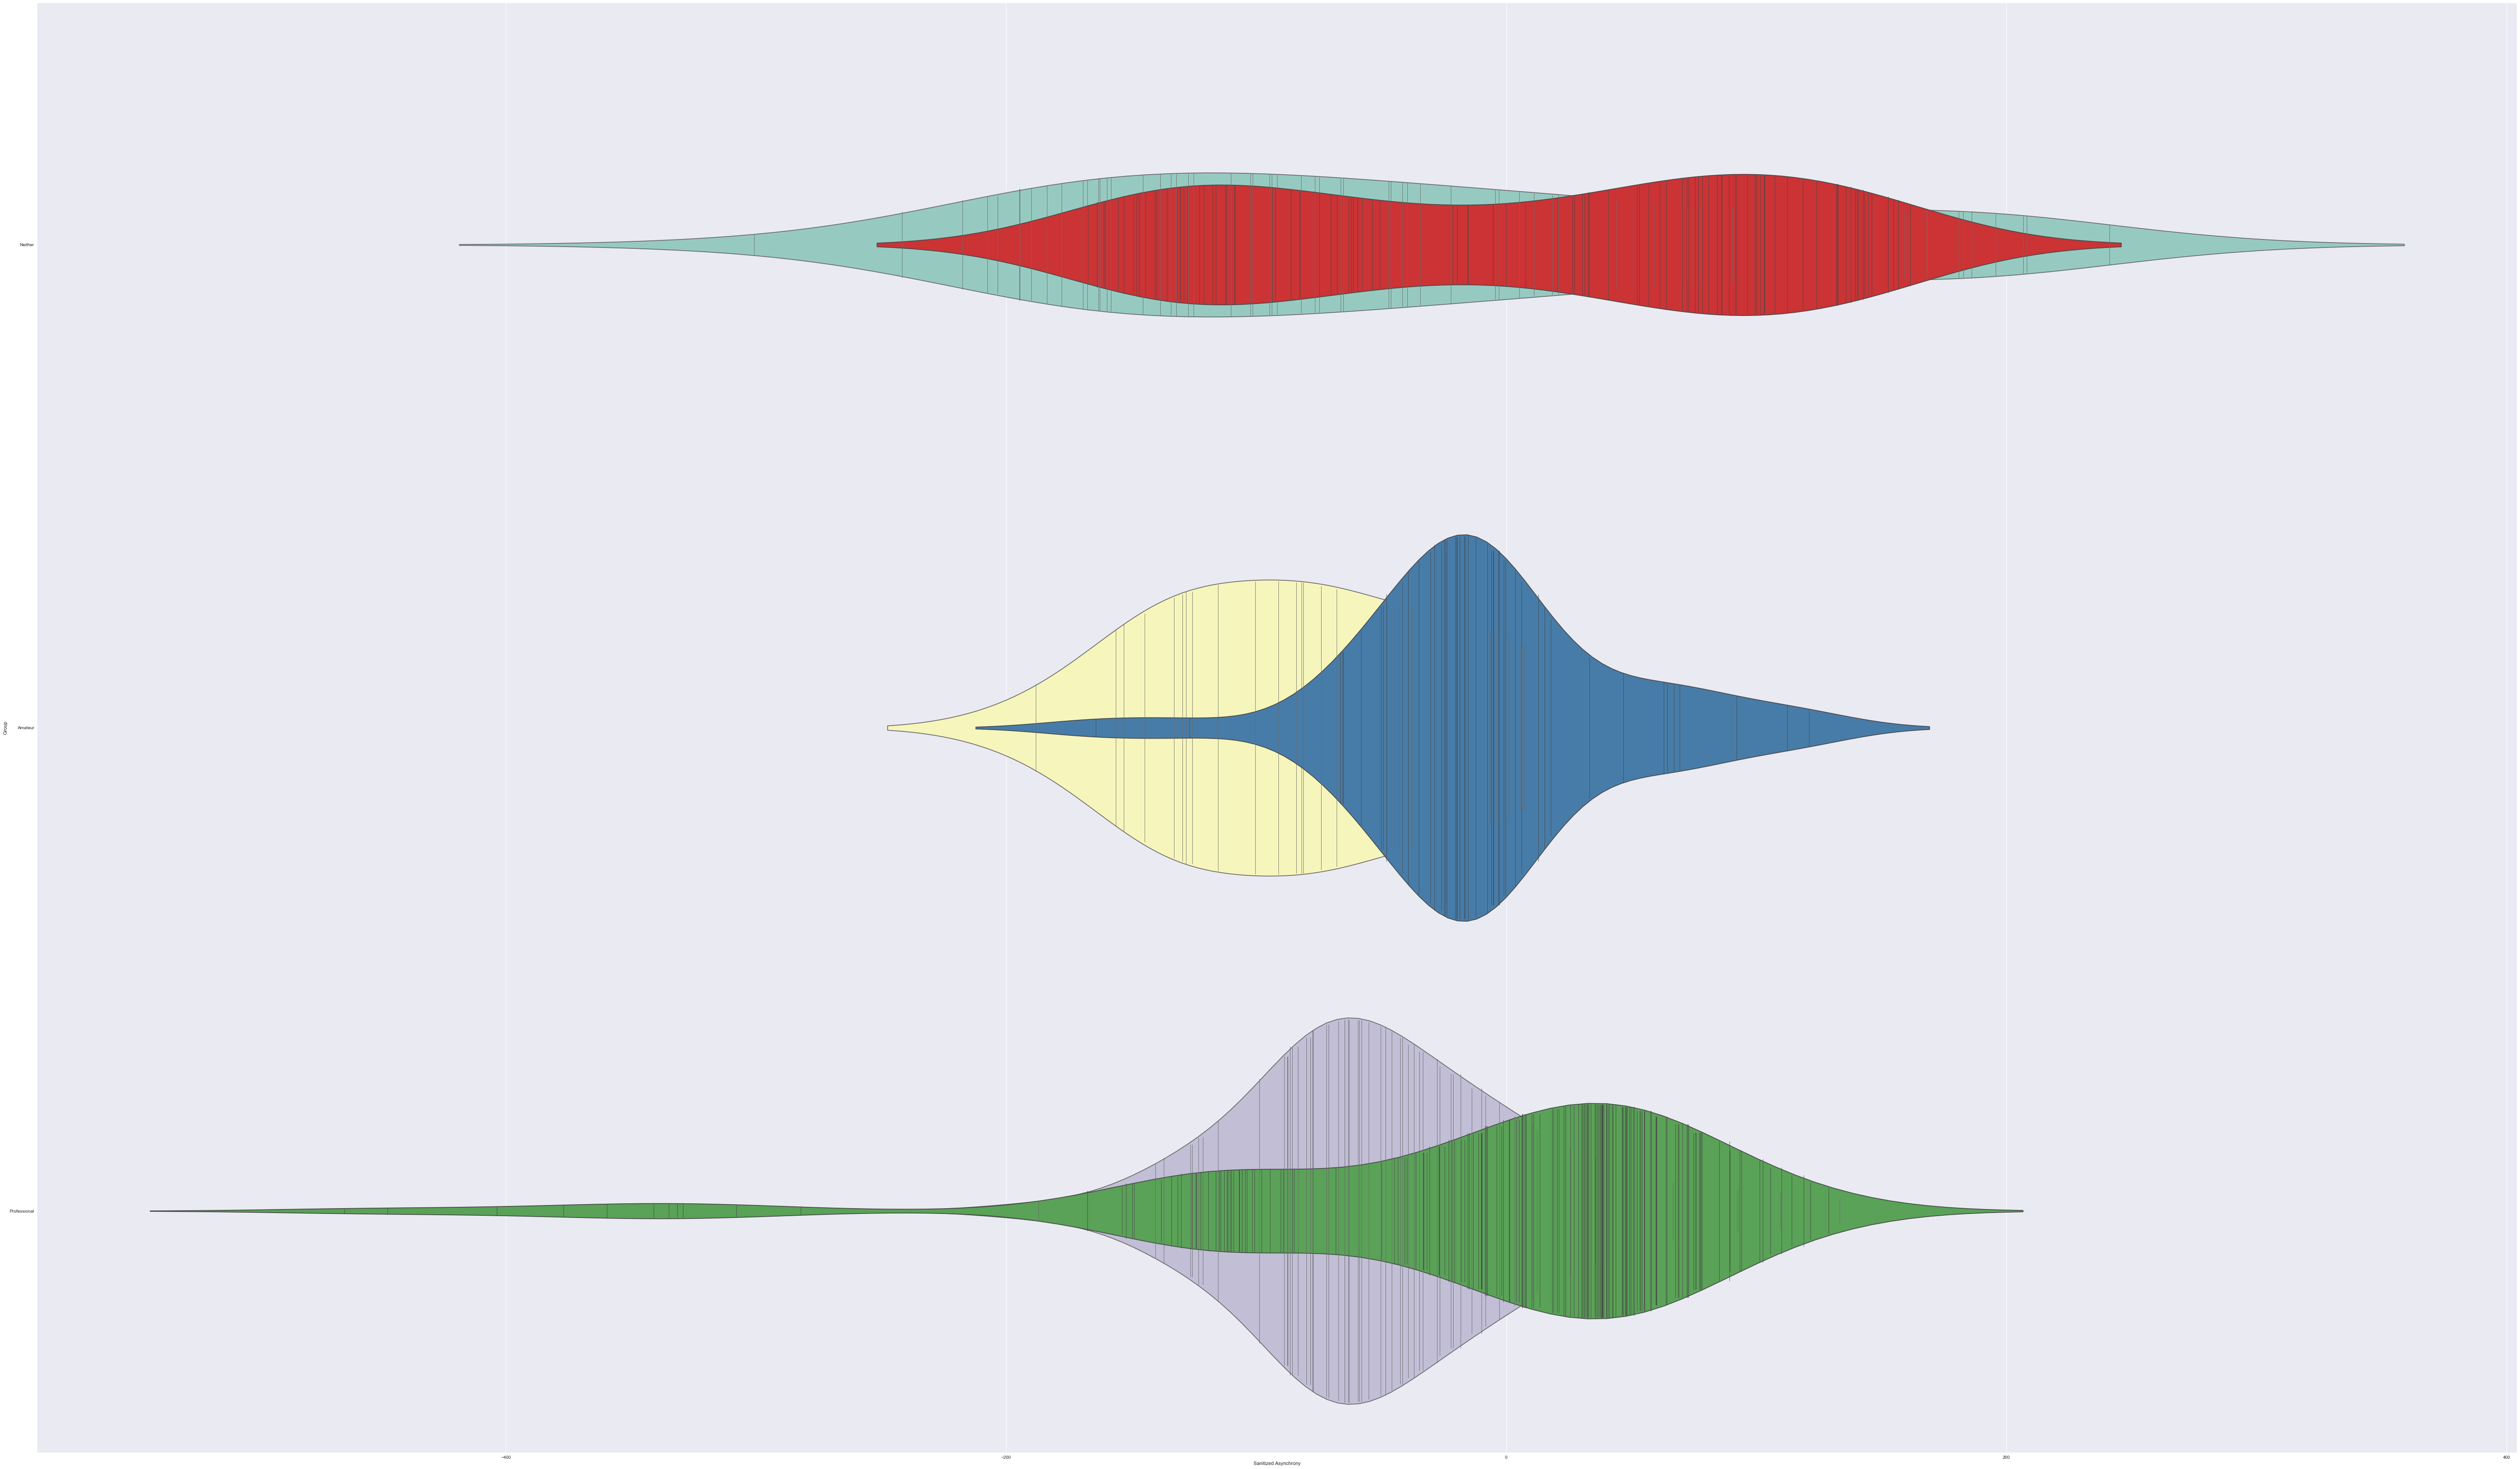

In [275]:
sns.violinplot(df["Sanitized Asynchrony"][df.Test == 'A1a1'],df.Group,split=True, inner="stick", palette="Set3")
sns.violinplot(df["Sanitized Asynchrony"][df.Test == 'H1a1'],df.Group,split=True, inner="stick", palette="Set1")

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

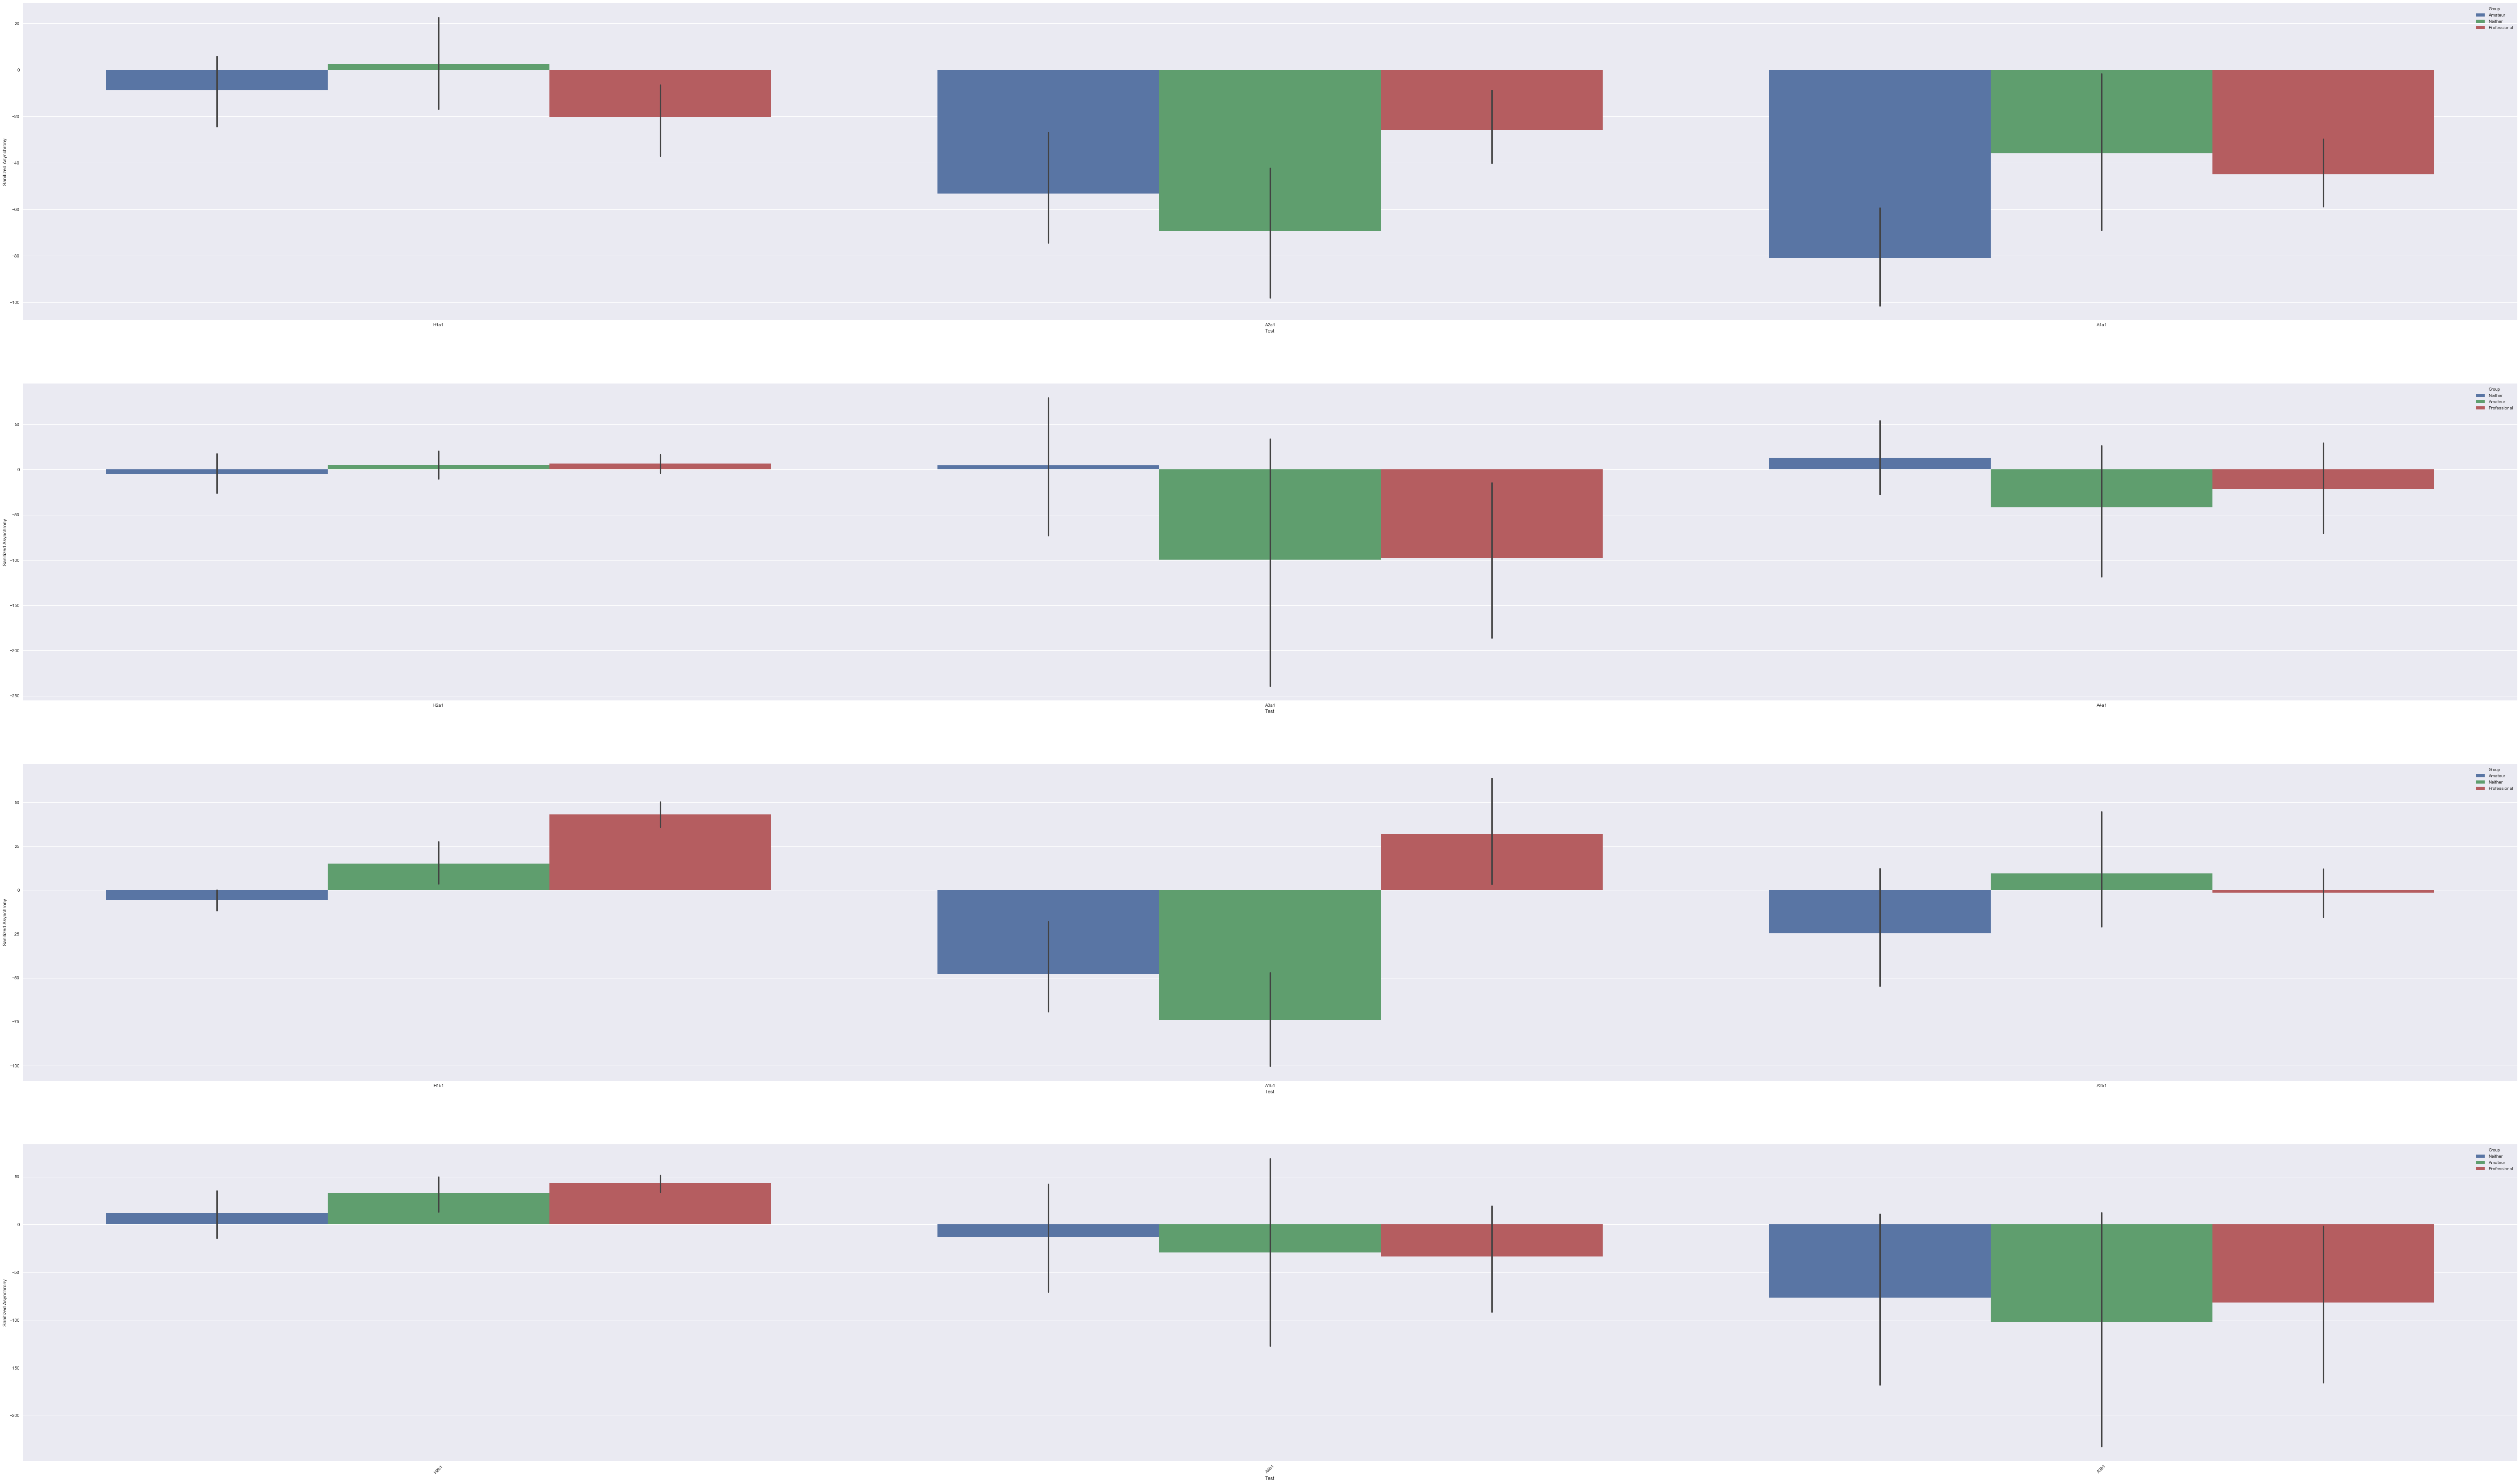

In [276]:
fig, axs = plt.subplots(nrows=4)
testList= ['A1a1','A2a1','H1a1']
testList2 = ['A3a1','A4a1','H2a1']
testList3 = ['A1b1','A2b1','H1b1']
testList4= ['A3b1','A4b1','H2b1']
newdf = df[df.Test.isin(testList)]
newdf2 = df[df.Test.isin(testList2)]
newdf3 = df[df.Test.isin(testList3)]
newdf4 = df[df.Test.isin(testList4)]
sns.barplot(y="Sanitized Asynchrony", x="Test", hue="Group", data=newdf,dodge=True,ax=axs[0])
sns.barplot(y="Sanitized Asynchrony", x="Test", hue="Group", data=newdf2,dodge=True,ax=axs[1])
sns.barplot(y="Sanitized Asynchrony", x="Test", hue="Group", data=newdf3,dodge=True,ax=axs[2])
sns.barplot(y="Sanitized Asynchrony", x="Test", hue="Group", data=newdf4,dodge=True,ax=axs[3])
plt.xticks(rotation=45)

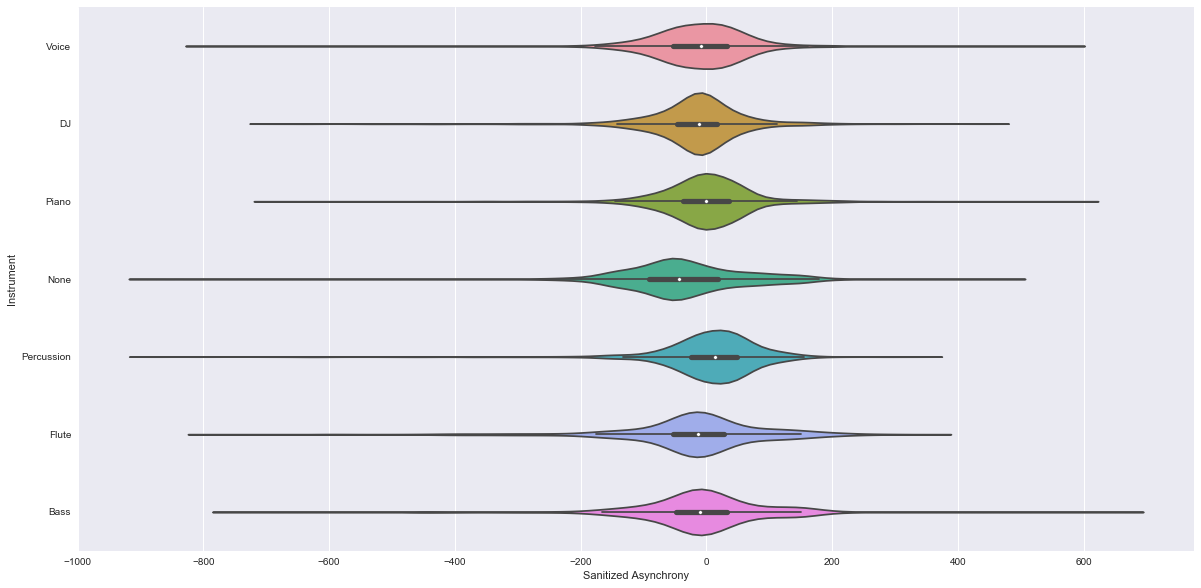

In [72]:
sns.violinplot(df["Sanitized Asynchrony"],df.Instrument)

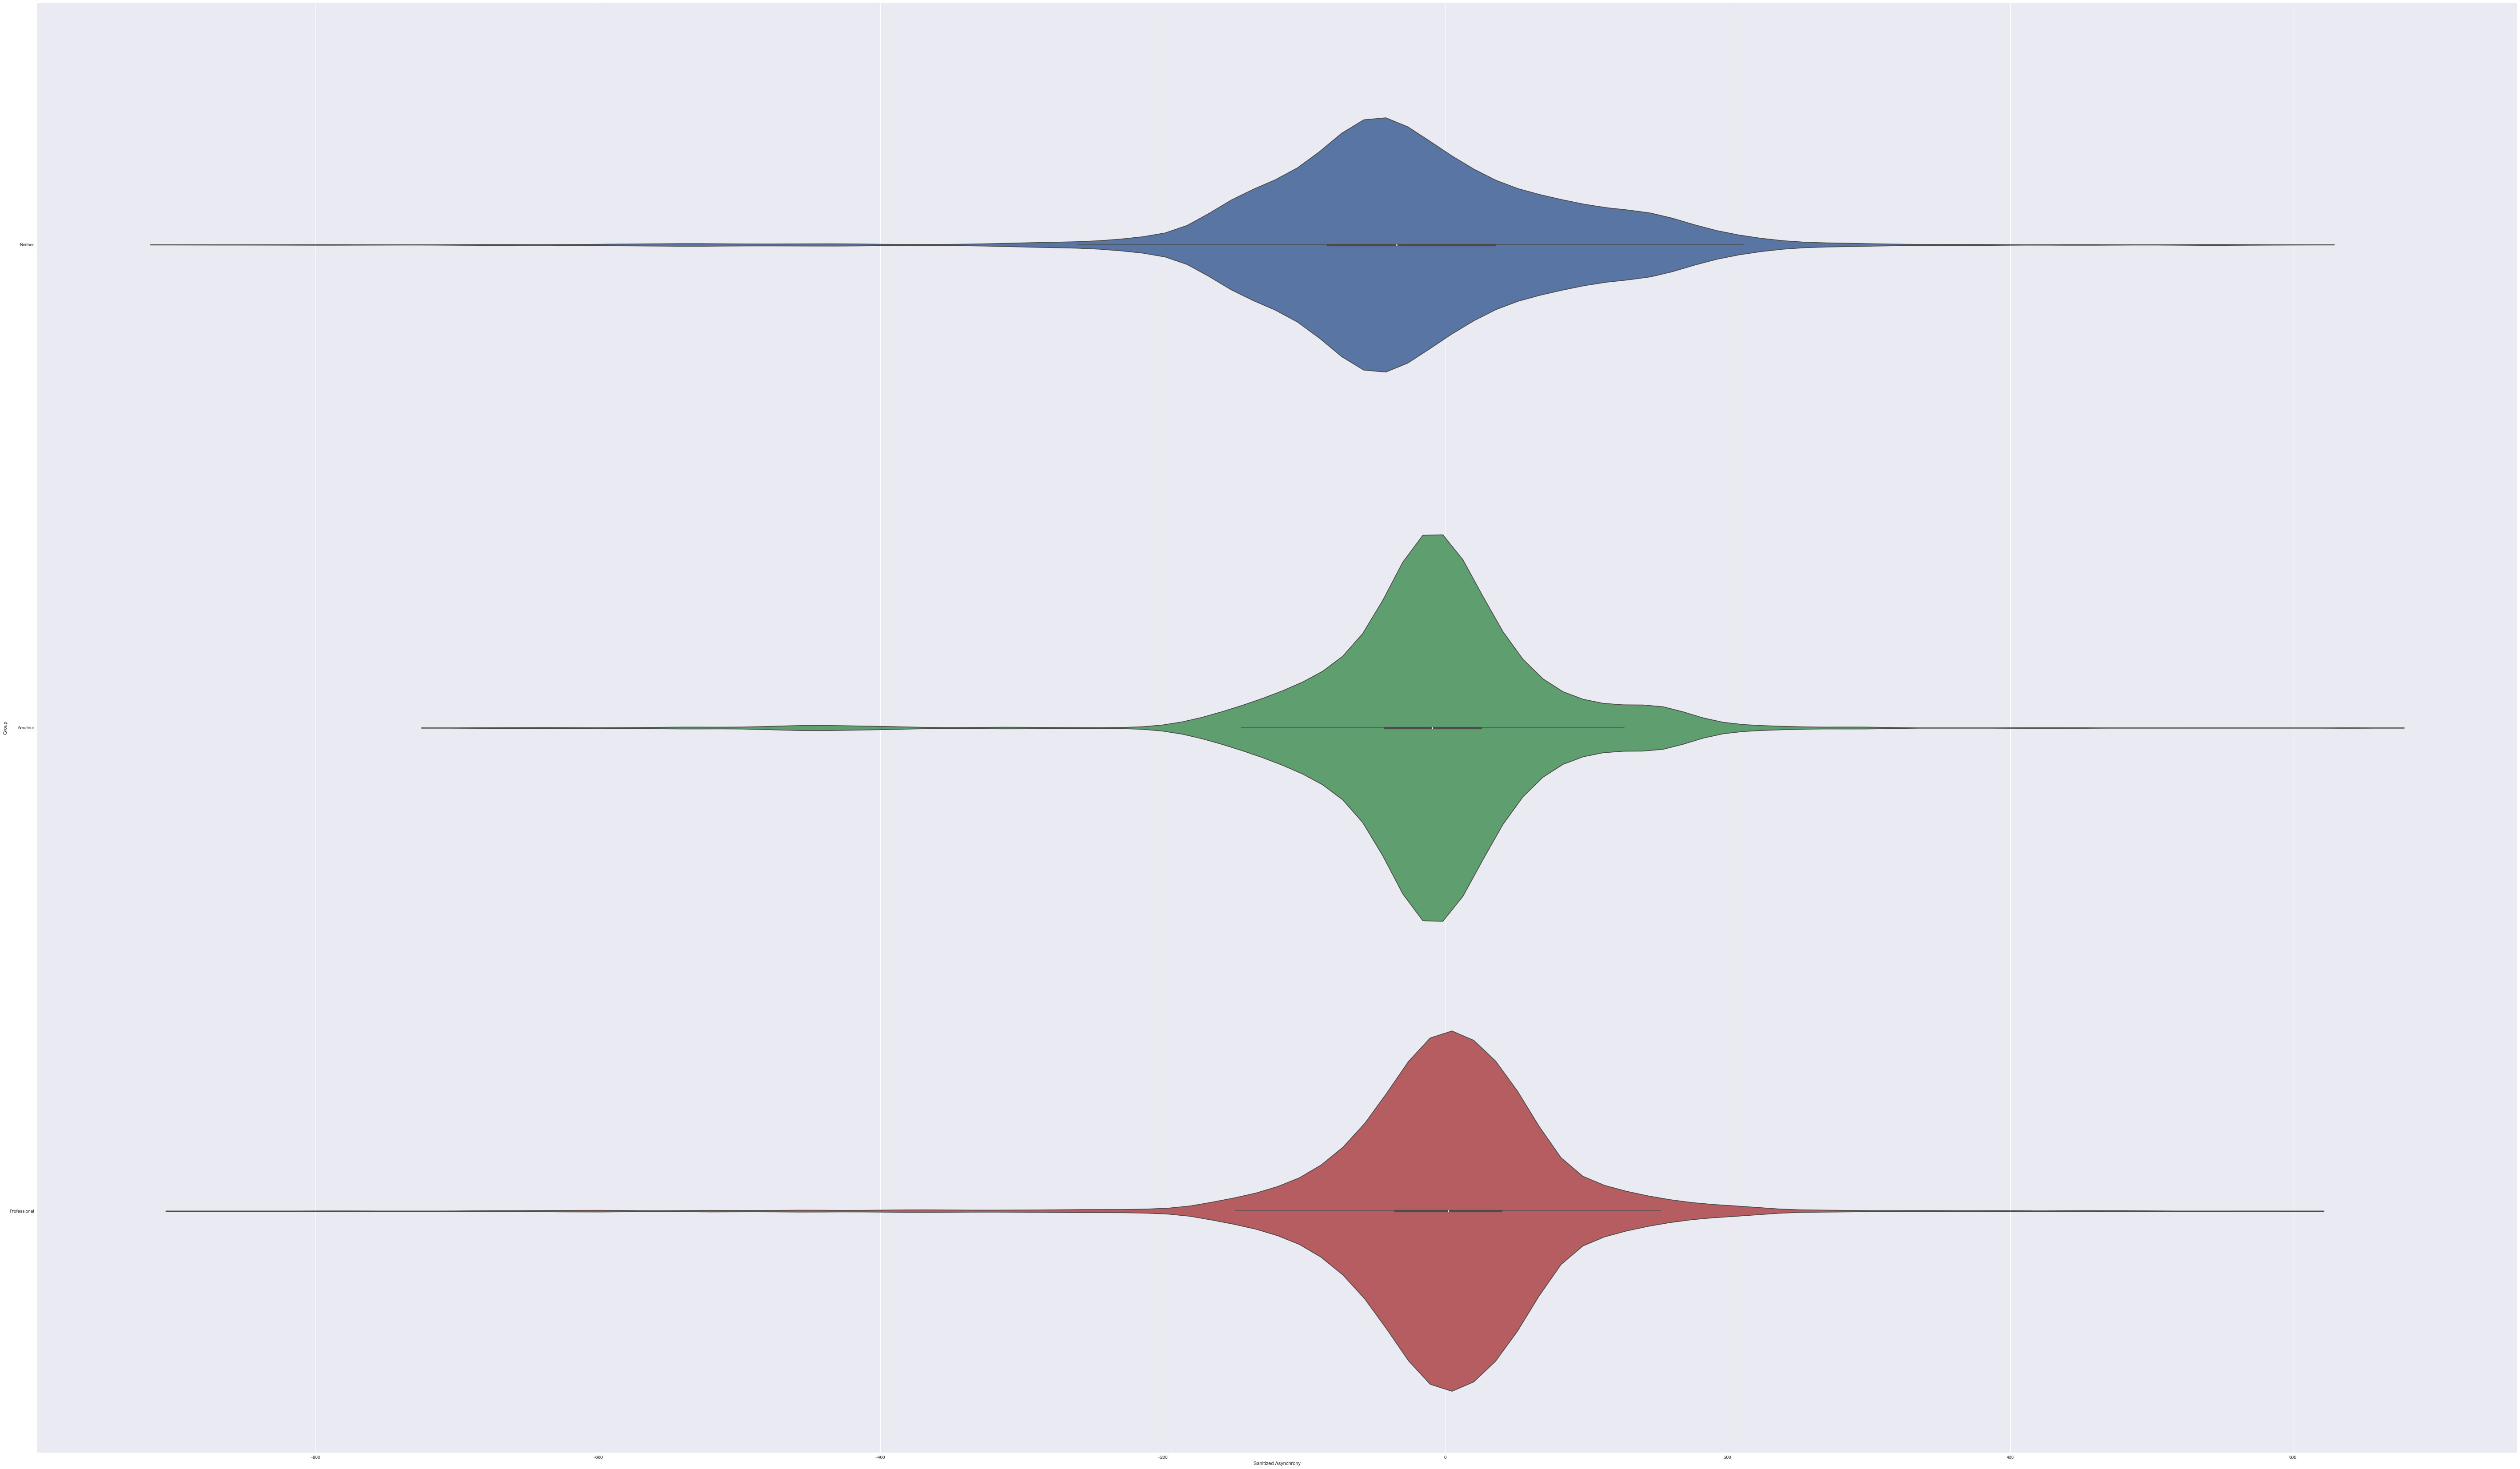

In [277]:
sns.violinplot(df["Sanitized Asynchrony"],df.Group)

In [15]:
def paired_ttest(x, y):
    """
    Function that will calculate the t-ratio
    :param x: list of scores in first condition
    :param y: list of scores in second condition
    :return statistics: a dictionary containing the t-value, p-value,
    and degrees of freedom
    """
    # Difference scores are going to be stored in a list
    di = []
    # Sample size = the length of variable x
    n = len(x)
    df = n-1

    # For each subject append the difference score between x & y
    # i is the index so we do the substraction for each subjects score on x and y
    for i in range(n):
        di.append(x[i] - y[i])

    # Avarage of the difference score. Note, division of integers in Python will result in an integer. Thus, we need
    # to convert one of the numbers to float datatype (using float())
    dbar = float(sum(di))/n

    # Calculation of standard deviation for the difference score
    std_di = 0

    # Each subjects difference score is subtracted by the avarage and exponated (i.e., "**2)
    for d in di:
        std_di += (d-dbar)**2

    # We get the standard deviation by dividing what was calculated above (std_di) by sample size (n). This value is
    # squared.
    std_di = np.sqrt(std_di/n)

    # Standard error of the mean is simple: standard deviation divided by the sample size -1 squared.
    se_dbar = std_di/np.sqrt(n-1)

    # T-ratio is calculated by dividing the avarage by the standard error of the mean
    t_val = dbar/se_dbar

    # P-value
    pval = t.sf(np.abs(t_val), df) * 2.

    # Last, we create the dictionary containing the needed statistics
    statistics = {'T-value': t_val, 'Degree of Freedom': df, 'P-value': pval}

    # Function returns a dictionary:
    return statistics

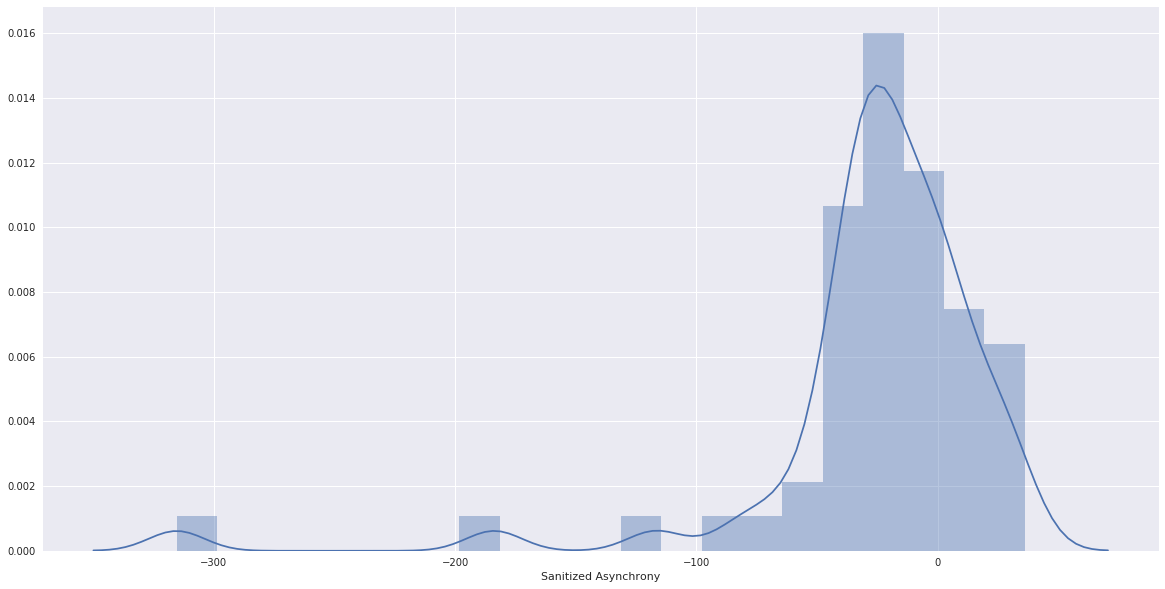

In [153]:
#Performance per Test
group_df = df.groupby(['Test'])
test = group_df['Sanitized Asynchrony'].mean()
sns.distplot(test);

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



count       mean         std      min      25%      50%  \
Instrument                                                             
Bass         861.0  -4.135114  101.707499 -583.650 -41.6800  -5.2120   
DJ          1297.0 -16.486040   83.919512 -685.619 -43.6750 -10.6040   
Flute        831.0 -20.070209  118.446653 -764.643 -54.1465 -12.3440   
None        4003.0 -21.154583  112.696054 -875.079 -77.9700 -30.0770   
Percussion  1389.0   7.448904   90.112418 -874.445 -19.9080  17.1570   
Piano       3511.0  -8.866428   90.662650 -687.020 -50.3960  -4.9530   
Voice       1380.0  -8.282513   94.840467 -783.868 -48.4225  -3.5655   

                 75%      max  
Instrument                     
Bass        36.19200  639.355  
DJ          18.89800  302.431  
Flute       27.76300  329.070  
None        39.93250  587.443  
Percussion  50.12600  331.111  
Piano       35.17750  590.427  
Voice       34.92125  557.114

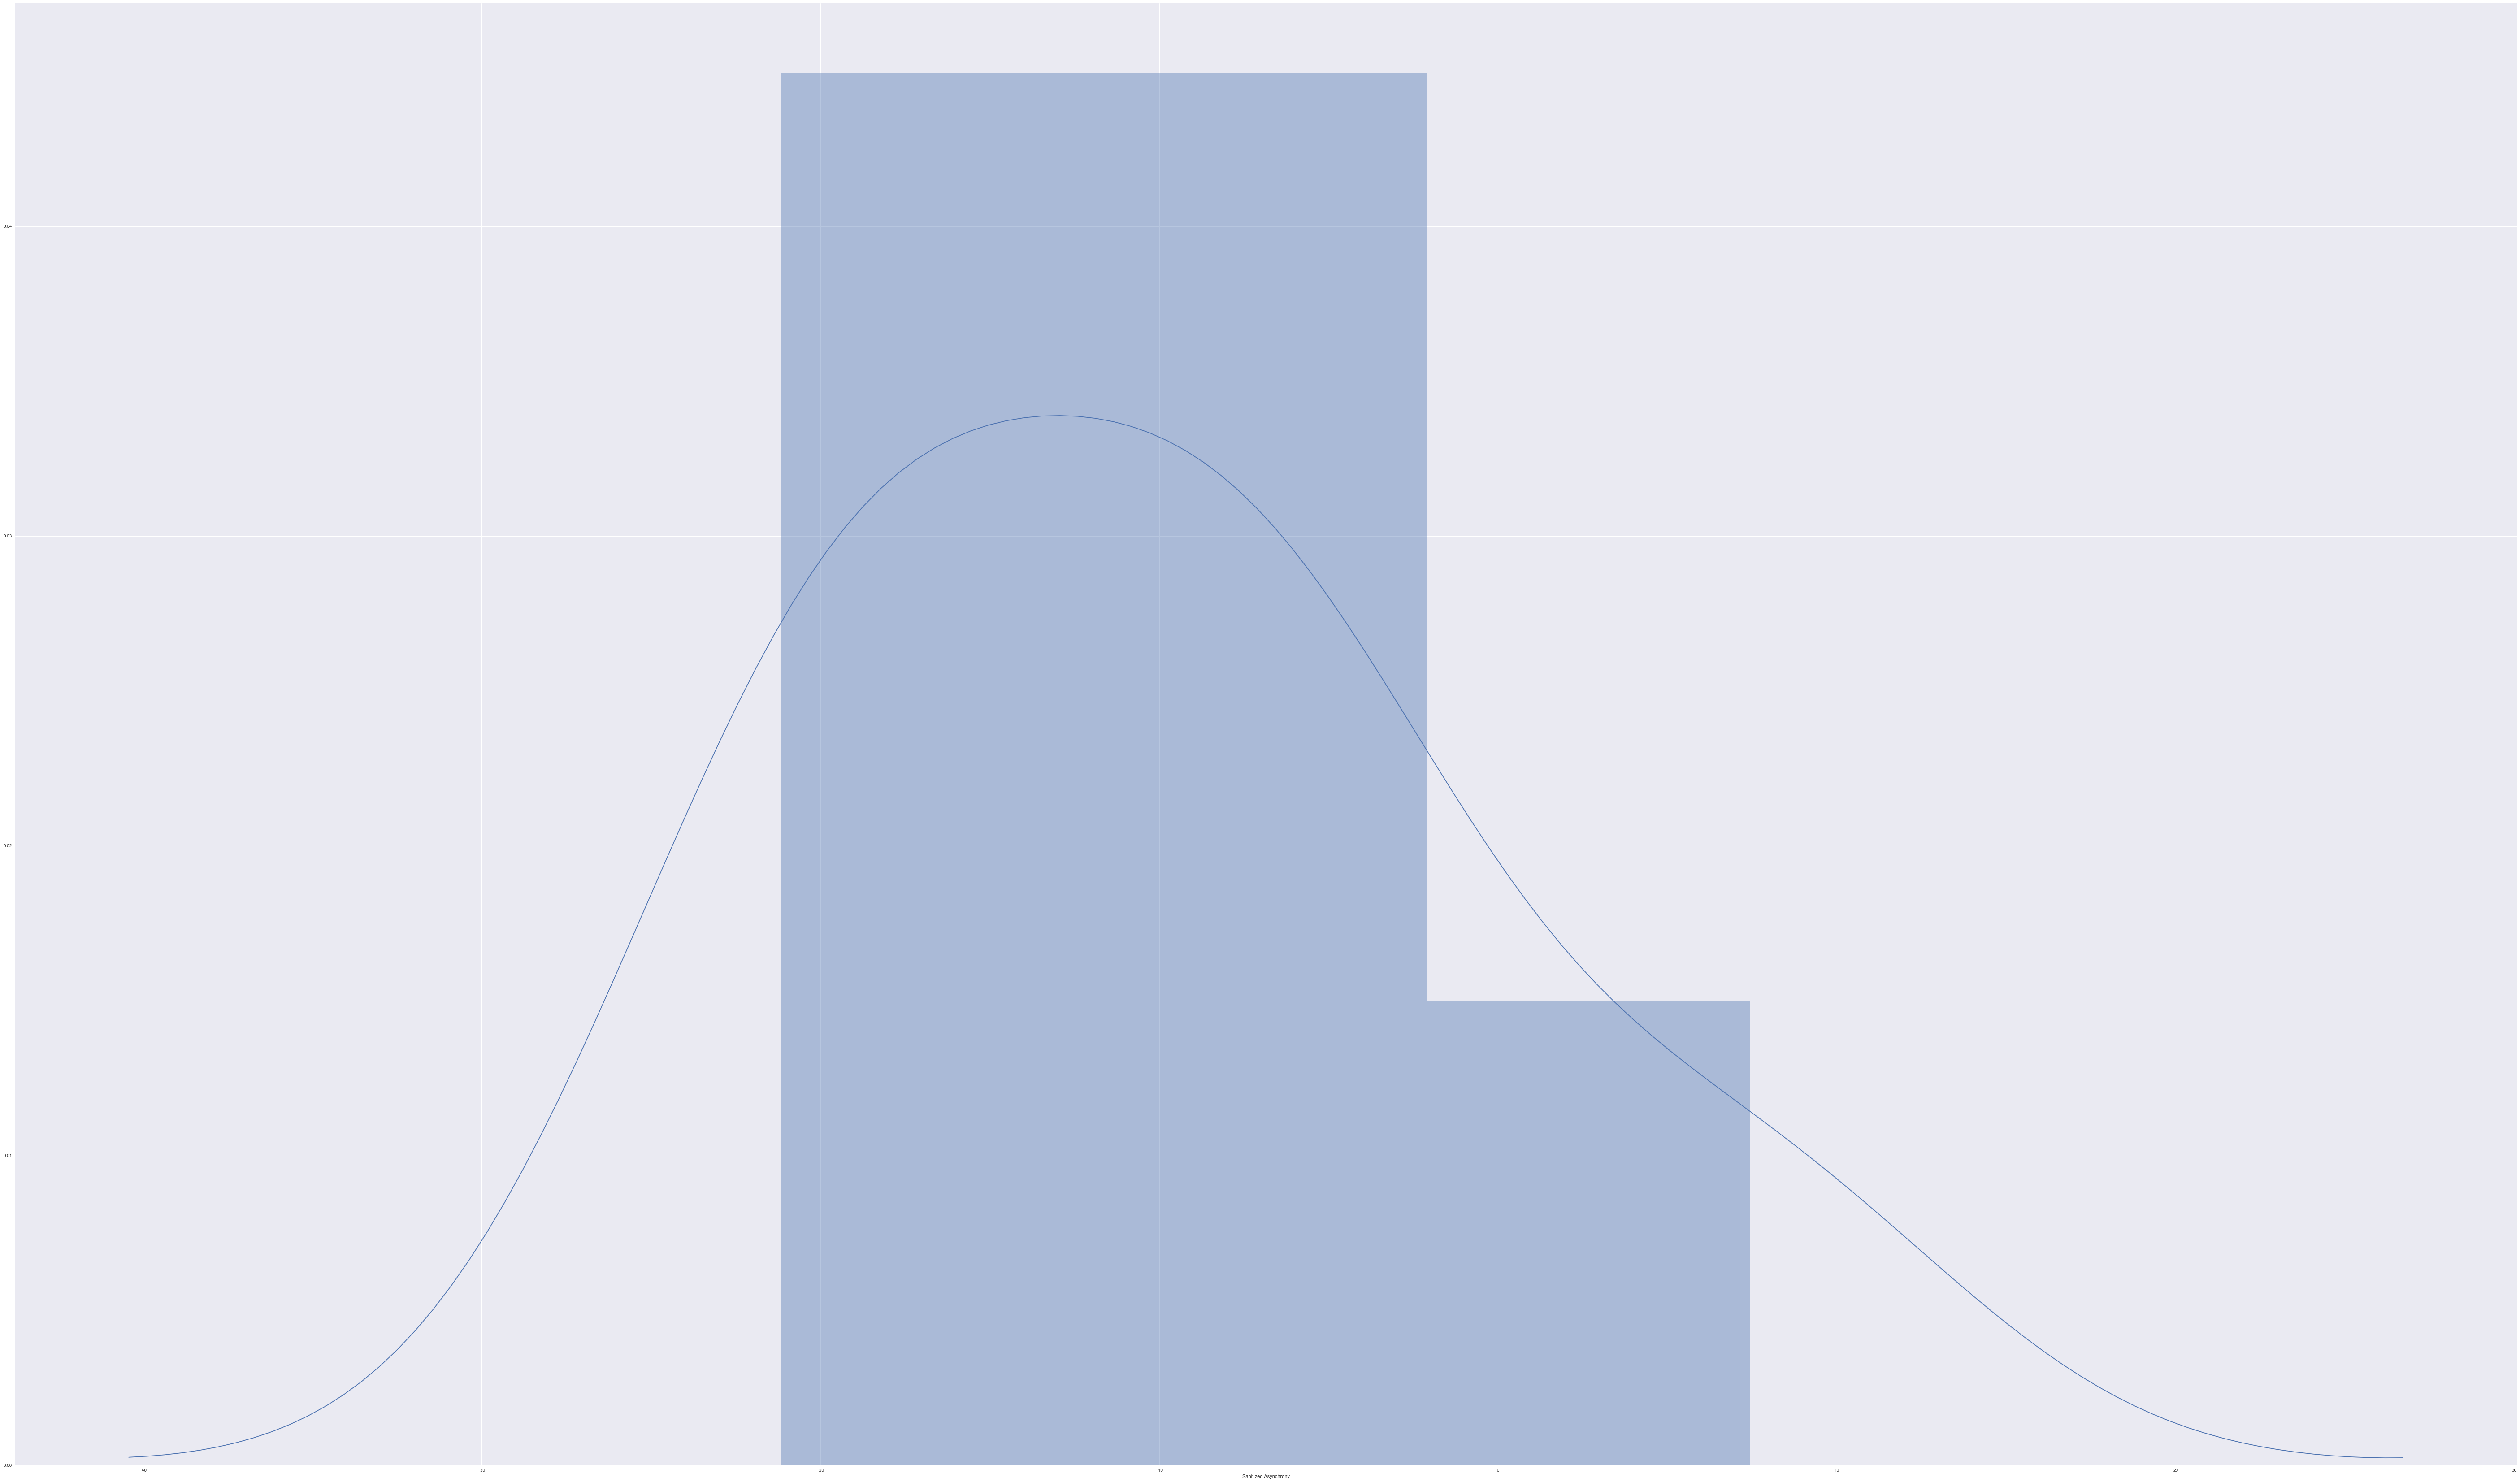

In [279]:
#Performance per User per Test
# grouped_df = pd.groupby(['Test','Group','Instrument','User ID']);
grouped_df = df.groupby(['Instrument']);
x = grouped_df['Sanitized Asynchrony'].mean()
sns.distplot(x)
grouped_df['Sanitized Asynchrony'].describe()

In [280]:
means = grouped_df['Sanitized Asynchrony'].mean()
x, y = means['A1a1'].values,means['A3a1'].values
t_value = paired_ttest(x,y)
for key, value in t_value.items():
    t_value[key] = round(value, 3)
 
print(t_value)

KeyError: 'A1a1'

In [40]:
stats.ttest_rel(a=x,b=y)

Ttest_relResult(statistic=0.9726996797647363, pvalue=0.3561181440073)

In [26]:
stats.t.ppf(q=0.025,df=9)

-2.262157162740992

In [28]:
stats.t.ppf(q=0.975,df=9)

2.2621571627409915

In [31]:
stats.t.cdf(x=-0.53,df=9)*2

0.6089366906430735

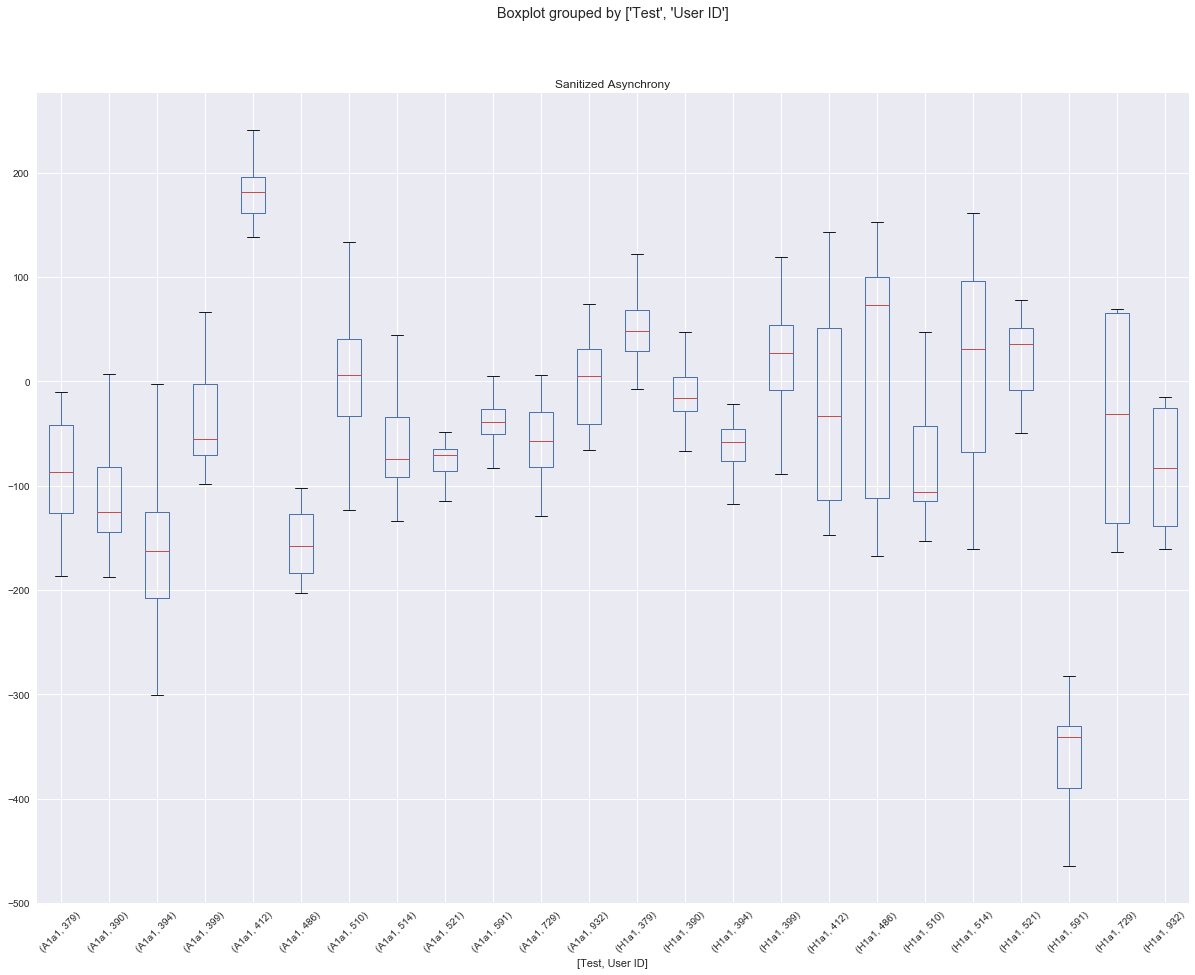

In [278]:
fig,ax = plt.subplots(figsize=(20,15))
compare_1 = df.loc[df['Test'].isin(['A1a1','H1a1'])];
compare_1.boxplot(column=['Sanitized Asynchrony'],by=['Test','User ID'],ax=ax);
plt.xticks(rotation=45);
# compare_1.iplot(kind='box',filename='cufflinks/box-plots')